# Task-Specific Analysis

This notebook provides deep analysis of performance patterns for specific task types: Graph Classification, Node Classification, and Link Prediction.

## Step 3.1: Graph Classification Analysis

**Focus:** Deep analysis of graph classification performance (ENZYMES, PTC_MR)

**Objectives:**
- Extract and analyze ENZYMES and PTC_MR results
- Compare performance patterns between datasets
- Identify most effective pre-training schemes for graph-level tasks
- Statistical comparison and transferable insights


In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Define paths
RESULTS_DIR = Path('results')
FIGURES_DIR = Path('figures')
FIGURES_DIR.mkdir(exist_ok=True)

print("Task-Specific Analysis Setup Complete!")


Task-Specific Analysis Setup Complete!


In [14]:
# Load the aggregated and raw data
try:
    # Load aggregated results
    agg_df = pd.read_csv(RESULTS_DIR / 'aggregated_results.csv')
    
    # Load raw experimental results
    raw_df = pd.read_csv(RESULTS_DIR / 'raw_experimental_results.csv')
    
    print(f"Loaded aggregated data: {len(agg_df)} combinations")
    print(f"Loaded raw data: {len(raw_df)} experiments")
    
    # Display basic info
    print("\nDomains available:")
    print(agg_df['domain_name'].unique())
    
    print("\nTask types:")
    print(agg_df['task_type'].unique())
    
except FileNotFoundError as e:
    print(f"Data files not found. Please ensure the previous analysis steps have been completed.")
    print(f"Missing file: {e.filename}")
    agg_df = raw_df = None


Loaded aggregated data: 108 combinations
Loaded raw data: 324 experiments

Domains available:
['CiteSeer_LP' 'CiteSeer_NC' 'Cora_LP' 'Cora_NC' 'ENZYMES' 'PTC_MR']

Task types:
['link_prediction' 'node_classification' 'graph_classification']


## Graph Classification Data Extraction and Overview


In [15]:
# Extract graph classification data
if agg_df is not None:
    # Filter for graph classification tasks
    graph_class_domains = ['ENZYMES', 'PTC_MR']
    graph_agg = agg_df[agg_df['domain_name'].isin(graph_class_domains)].copy()
    graph_raw = raw_df[raw_df['domain_name'].isin(graph_class_domains)].copy()
    
    print("=" * 60)
    print("GRAPH CLASSIFICATION DATA OVERVIEW")
    print("=" * 60)
    
    # Basic statistics
    print(f"\nDataset Characteristics:")
    for domain in graph_class_domains:
        domain_data = graph_agg[graph_agg['domain_name'] == domain]
        if not domain_data.empty:
            task_type = domain_data['task_type'].iloc[0]
            num_combinations = len(domain_data)
            print(f"  {domain}:")
            print(f"    - Task type: {task_type}")
            print(f"    - Combinations available: {num_combinations}")
            print(f"    - Schemes: {sorted(domain_data['pretrained_scheme'].unique())}")
            print(f"    - Strategies: {sorted(domain_data['finetune_strategy'].unique())}")
    
    # Performance overview
    print(f"\nPerformance Overview:")
    for domain in graph_class_domains:
        domain_data = graph_agg[graph_agg['domain_name'] == domain]
        if not domain_data.empty:
            accuracy_stats = domain_data['accuracy_mean'].describe()
            print(f"\n  {domain} Accuracy Statistics:")
            print(f"    - Mean: {accuracy_stats['mean']:.4f}")
            print(f"    - Std: {accuracy_stats['std']:.4f}")
            print(f"    - Min: {accuracy_stats['min']:.4f}")
            print(f"    - Max: {accuracy_stats['max']:.4f}")
            
            # Best performing combination
            best_idx = domain_data['accuracy_mean'].idxmax()
            best_combo = domain_data.loc[best_idx]
            print(f"    - Best: {best_combo['pretrained_scheme']}-{best_combo['finetune_strategy']} ({best_combo['accuracy_mean']:.4f})")
    
else:
    print("Cannot perform analysis without data. Please run previous steps first.")
    graph_agg = graph_raw = None


GRAPH CLASSIFICATION DATA OVERVIEW

Dataset Characteristics:
  ENZYMES:
    - Task type: graph_classification
    - Combinations available: 18
    - Schemes: ['b1', 'b2', 'b3', 'b4', 's1', 's2', 's3', 's4', 's5']
    - Strategies: ['full_finetune', 'linear_probe']
  PTC_MR:
    - Task type: graph_classification
    - Combinations available: 18
    - Schemes: ['b1', 'b2', 'b3', 'b4', 's1', 's2', 's3', 's4', 's5']
    - Strategies: ['full_finetune', 'linear_probe']

Performance Overview:

  ENZYMES Accuracy Statistics:
    - Mean: 0.5352
    - Std: 0.1063
    - Min: 0.3611
    - Max: 0.6667
    - Best: b1-full_finetune (0.6667)

  PTC_MR Accuracy Statistics:
    - Mean: 0.5370
    - Std: 0.0602
    - Min: 0.4095
    - Max: 0.6857
    - Best: s1-full_finetune (0.6857)


## Scheme Effectiveness Analysis for Graph Classification


In [16]:
# Analyze scheme effectiveness for graph classification
if graph_agg is not None:
    print("=" * 60)
    print("SCHEME EFFECTIVENESS FOR GRAPH CLASSIFICATION")
    print("=" * 60)
    
    # Calculate baseline performance for each domain
    baseline_performance = {}
    for domain in graph_class_domains:
        baseline_data = graph_agg[
            (graph_agg['domain_name'] == domain) & 
            (graph_agg['pretrained_scheme'] == 'b1')
        ]
        if not baseline_data.empty:
            baseline_performance[domain] = baseline_data['accuracy_mean'].mean()
    
    print(f"\nBaseline Performance (b1):")
    for domain, perf in baseline_performance.items():
        print(f"  {domain}: {perf:.4f}")
    
    # Analyze scheme performance and improvement over baseline
    scheme_analysis = []
    schemes = sorted(graph_agg['pretrained_scheme'].unique())
    
    for domain in graph_class_domains:
        if domain not in baseline_performance:
            continue
            
        baseline_perf = baseline_performance[domain]
        domain_data = graph_agg[graph_agg['domain_name'] == domain]
        
        for scheme in schemes:
            scheme_data = domain_data[domain_data['pretrained_scheme'] == scheme]
            if not scheme_data.empty:
                mean_acc = scheme_data['accuracy_mean'].mean()
                std_acc = scheme_data['accuracy_mean'].std()
                improvement = ((mean_acc - baseline_perf) / baseline_perf) * 100
                
                # Calculate rank within domain
                domain_scheme_means = domain_data.groupby('pretrained_scheme')['accuracy_mean'].mean()
                rank = domain_scheme_means.rank(ascending=False)[scheme]
                
                scheme_analysis.append({
                    'domain': domain,
                    'scheme': scheme,
                    'mean_accuracy': mean_acc,
                    'std_accuracy': std_acc,
                    'improvement_pct': improvement,
                    'rank_in_domain': rank,
                    'num_combinations': len(scheme_data)
                })
    
    scheme_df = pd.DataFrame(scheme_analysis)
    
    print(f"\nScheme Performance Analysis:")
    print(scheme_df.round(4))
    
    # Best schemes per domain
    print(f"\nBest Schemes per Domain:")
    for domain in graph_class_domains:
        domain_schemes = scheme_df[scheme_df['domain'] == domain]
        if not domain_schemes.empty:
            best_scheme = domain_schemes.loc[domain_schemes['improvement_pct'].idxmax()]
            print(f"  {domain}: {best_scheme['scheme']} (+{best_scheme['improvement_pct']:.2f}%, rank {best_scheme['rank_in_domain']:.0f})")
    
    # Save the analysis results
    scheme_df.to_csv(RESULTS_DIR / 'graph_classification_analysis.csv', index=False)
    print(f"\nAnalysis saved to: {RESULTS_DIR / 'graph_classification_analysis.csv'}")
    
else:
    scheme_df = None


SCHEME EFFECTIVENESS FOR GRAPH CLASSIFICATION

Baseline Performance (b1):
  ENZYMES: 0.5806
  PTC_MR: 0.5286

Scheme Performance Analysis:
     domain scheme  mean_accuracy  std_accuracy  improvement_pct  \
0   ENZYMES     b1         0.5806        0.1218           0.0000   
1   ENZYMES     b2         0.5500        0.1179          -5.2632   
2   ENZYMES     b3         0.4972        0.1925         -14.3541   
3   ENZYMES     b4         0.5444        0.1650          -6.2201   
4   ENZYMES     s1         0.4750        0.1375         -18.1818   
5   ENZYMES     s2         0.5417        0.1218          -6.6986   
6   ENZYMES     s3         0.5361        0.1296          -7.6555   
7   ENZYMES     s4         0.5333        0.1257          -8.1340   
8   ENZYMES     s5         0.5583        0.1296          -3.8278   
9    PTC_MR     b1         0.5286        0.0337           0.0000   
10   PTC_MR     b2         0.5619        0.0000           6.3063   
11   PTC_MR     b3         0.5190        0.03

## Cross-Dataset Consistency Analysis


In [17]:
# Analyze consistency between ENZYMES and PTC_MR
if scheme_df is not None:
    print("=" * 60)
    print("CROSS-DATASET CONSISTENCY ANALYSIS")
    print("=" * 60)
    
    # Create pivot table for easier comparison
    pivot_improvement = scheme_df.pivot(index='scheme', columns='domain', values='improvement_pct')
    pivot_rank = scheme_df.pivot(index='scheme', columns='domain', values='rank_in_domain')
    
    print(f"\nImprovement Percentage by Scheme:")
    print(pivot_improvement.round(2))
    
    print(f"\nRank by Scheme (1 = best):")
    print(pivot_rank.round(0))
    
    # Calculate correlation between datasets
    if 'ENZYMES' in pivot_improvement.columns and 'PTC_MR' in pivot_improvement.columns:
        # Remove NaN values for correlation calculation
        valid_data = pivot_improvement.dropna()
        
        if len(valid_data) > 1:
            # Performance correlation
            perf_corr, perf_p = spearmanr(valid_data['ENZYMES'], valid_data['PTC_MR'])
            print(f"\nPerformance Correlation:")
            print(f"  Spearman correlation: {perf_corr:.3f} (p={perf_p:.3f})")
            
            # Rank correlation
            valid_ranks = pivot_rank.dropna()
            if len(valid_ranks) > 1:
                rank_corr, rank_p = spearmanr(valid_ranks['ENZYMES'], valid_ranks['PTC_MR'])
                print(f"  Rank correlation: {rank_corr:.3f} (p={rank_p:.3f})")
            
            # Identify consistent performers
            print(f"\nConsistent Top Performers (top 3 in both datasets):")
            enzymes_top3 = valid_ranks['ENZYMES'].nsmallest(3).index
            ptc_top3 = valid_ranks['PTC_MR'].nsmallest(3).index
            consistent_top = set(enzymes_top3) & set(ptc_top3)
            
            if consistent_top:
                for scheme in consistent_top:
                    e_rank = valid_ranks.loc[scheme, 'ENZYMES']
                    p_rank = valid_ranks.loc[scheme, 'PTC_MR']
                    e_imp = valid_data.loc[scheme, 'ENZYMES']
                    p_imp = valid_data.loc[scheme, 'PTC_MR']
                    print(f"  {scheme}: ENZYMES rank {e_rank:.0f} (+{e_imp:.2f}%), PTC_MR rank {p_rank:.0f} (+{p_imp:.2f}%)")
            else:
                print(f"  No schemes consistently in top 3 for both datasets")
    
else:
    pivot_improvement = pivot_rank = None


CROSS-DATASET CONSISTENCY ANALYSIS

Improvement Percentage by Scheme:
domain  ENZYMES  PTC_MR
scheme                 
b1         0.00    0.00
b2        -5.26    6.31
b3       -14.35   -1.80
b4        -6.22    0.00
s1       -18.18   26.13
s2        -6.70    0.00
s3        -7.66    0.90
s4        -8.13   -7.21
s5        -3.83   -9.91

Rank by Scheme (1 = best):
domain  ENZYMES  PTC_MR
scheme                 
b1          1.0     5.0
b2          3.0     2.0
b3          8.0     7.0
b4          4.0     5.0
s1          9.0     1.0
s2          5.0     5.0
s3          6.0     3.0
s4          7.0     8.0
s5          2.0     9.0

Performance Correlation:
  Spearman correlation: -0.203 (p=0.600)
  Rank correlation: -0.203 (p=0.600)

Consistent Top Performers (top 3 in both datasets):
  b2: ENZYMES rank 3 (+-5.26%), PTC_MR rank 2 (+6.31%)


## Graph Classification Visualizations


Creating Graph Classification Visualizations...


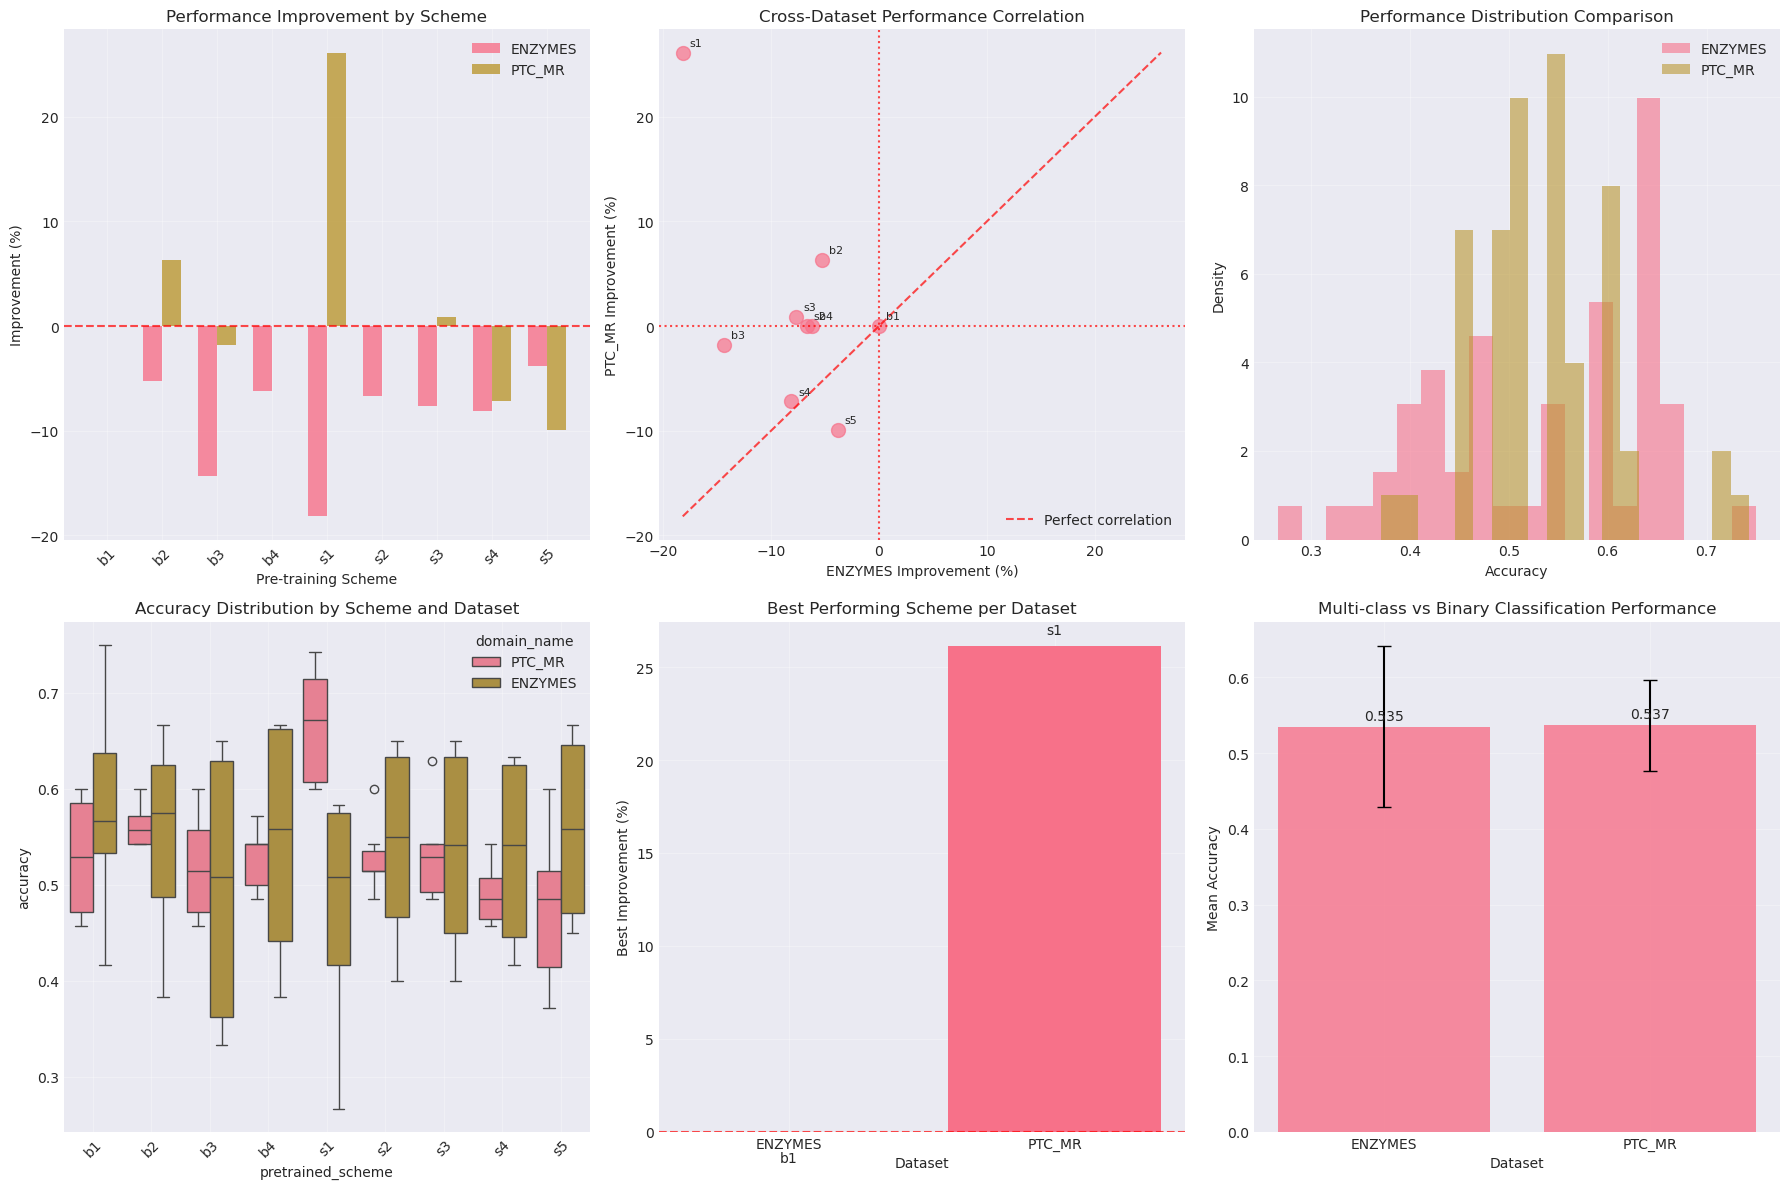

Graph classification visualization saved to: analysis/figures/graph_classification_comparison.png


In [18]:
# Create comprehensive visualizations for graph classification analysis
if scheme_df is not None and graph_raw is not None:
    print("Creating Graph Classification Visualizations...")
    
    plt.figure(figsize=(18, 12))
    
    # 1. Performance comparison by scheme
    plt.subplot(2, 3, 1)
    if pivot_improvement is not None:
        schemes = pivot_improvement.index
        x_pos = np.arange(len(schemes))
        width = 0.35
        
        enzymes_data = pivot_improvement['ENZYMES'].fillna(0)
        ptc_data = pivot_improvement['PTC_MR'].fillna(0)
        
        bars1 = plt.bar(x_pos - width/2, enzymes_data, width, label='ENZYMES', alpha=0.8)
        bars2 = plt.bar(x_pos + width/2, ptc_data, width, label='PTC_MR', alpha=0.8)
        
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.xlabel('Pre-training Scheme')
        plt.ylabel('Improvement (%)')
        plt.title('Performance Improvement by Scheme')
        plt.xticks(x_pos, schemes, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 2. Correlation scatter plot
    plt.subplot(2, 3, 2)
    if pivot_improvement is not None and 'ENZYMES' in pivot_improvement.columns and 'PTC_MR' in pivot_improvement.columns:
        valid_data = pivot_improvement.dropna()
        if not valid_data.empty:
            plt.scatter(valid_data['ENZYMES'], valid_data['PTC_MR'], alpha=0.7, s=100)
            
            # Add labels for each point
            for idx, scheme in enumerate(valid_data.index):
                plt.annotate(scheme, (valid_data.loc[scheme, 'ENZYMES'], valid_data.loc[scheme, 'PTC_MR']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
            
            # Add diagonal line
            min_val = min(valid_data.min())
            max_val = max(valid_data.max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect correlation')
            
            plt.axhline(y=0, color='red', linestyle=':', alpha=0.7)
            plt.axvline(x=0, color='red', linestyle=':', alpha=0.7)
            plt.xlabel('ENZYMES Improvement (%)')
            plt.ylabel('PTC_MR Improvement (%)')
            plt.title('Cross-Dataset Performance Correlation')
            plt.legend()
            plt.grid(True, alpha=0.3)
    
    # 3. Performance distribution by dataset
    plt.subplot(2, 3, 3)
    enzymes_data = graph_raw[graph_raw['domain_name'] == 'ENZYMES']['accuracy']
    ptc_data = graph_raw[graph_raw['domain_name'] == 'PTC_MR']['accuracy']
    
    plt.hist(enzymes_data, alpha=0.6, label='ENZYMES', bins=20, density=True)
    plt.hist(ptc_data, alpha=0.6, label='PTC_MR', bins=20, density=True)
    plt.xlabel('Accuracy')
    plt.ylabel('Density')
    plt.title('Performance Distribution Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Box plot by scheme
    plt.subplot(2, 3, 4)
    graph_raw_plot = graph_raw.copy()
    sns.boxplot(data=graph_raw_plot, x='pretrained_scheme', y='accuracy', hue='domain_name')
    plt.xticks(rotation=45)
    plt.title('Accuracy Distribution by Scheme and Dataset')
    plt.grid(True, alpha=0.3)
    
    # 5. Best scheme visualization
    plt.subplot(2, 3, 5)
    best_schemes_data = []
    for domain in graph_class_domains:
        domain_data = scheme_df[scheme_df['domain'] == domain]
        if not domain_data.empty:
            best_scheme = domain_data.loc[domain_data['improvement_pct'].idxmax()]
            best_schemes_data.append({
                'domain': domain,
                'best_scheme': best_scheme['scheme'],
                'improvement': best_scheme['improvement_pct']
            })
    
    if best_schemes_data:
        best_df = pd.DataFrame(best_schemes_data)
        bars = plt.bar(best_df['domain'], best_df['improvement'])
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        
        # Add scheme labels on bars
        for bar, scheme in zip(bars, best_df['best_scheme']):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height > 0 else -1),
                    scheme, ha='center', va='bottom' if height > 0 else 'top', fontsize=10)
        
        plt.xlabel('Dataset')
        plt.ylabel('Best Improvement (%)')
        plt.title('Best Performing Scheme per Dataset')
        plt.grid(True, alpha=0.3)
    
    # 6. Multi-class vs Binary comparison
    plt.subplot(2, 3, 6)
    dataset_performance = graph_agg.groupby('domain_name')['accuracy_mean'].agg(['mean', 'std']).reset_index()
    
    bars = plt.bar(dataset_performance['domain_name'], dataset_performance['mean'], 
                  yerr=dataset_performance['std'], capsize=5, alpha=0.8)
    
    # Add value labels
    for bar, mean_val in zip(bars, dataset_performance['mean']):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                f'{mean_val:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.xlabel('Dataset')
    plt.ylabel('Mean Accuracy')
    plt.title('Multi-class vs Binary Classification Performance')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'graph_classification_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Graph classification visualization saved to: analysis/figures/graph_classification_comparison.png")
    
else:
    print("Cannot create visualizations without data. Please ensure previous steps completed successfully.")


## Summary and Recommendations


In [19]:
# Generate summary and recommendations for graph classification
if scheme_df is not None:
    print("=" * 60)
    print("GRAPH CLASSIFICATION SUMMARY AND RECOMMENDATIONS")
    print("=" * 60)
    
    # Key findings
    print("\nKEY FINDINGS:")
    
    # Best overall schemes
    overall_improvement = scheme_df.groupby('scheme')['improvement_pct'].mean().sort_values(ascending=False)
    print(f"\n1. BEST PERFORMING SCHEMES (average improvement):")
    for i, (scheme, improvement) in enumerate(overall_improvement.head(3).items()):
        print(f"   {i+1}. {scheme}: {improvement:.2f}%")
    
    # Dataset-specific findings
    print(f"\n2. DATASET-SPECIFIC INSIGHTS:")
    for domain in graph_class_domains:
        domain_data = scheme_df[scheme_df['domain'] == domain]
        if not domain_data.empty:
            best = domain_data.loc[domain_data['improvement_pct'].idxmax()]
            worst = domain_data.loc[domain_data['improvement_pct'].idxmin()]
            print(f"   {domain}:")
            print(f"     - Best: {best['scheme']} (+{best['improvement_pct']:.2f}%)")
            print(f"     - Worst: {worst['scheme']} ({worst['improvement_pct']:.2f}%)")
            print(f"     - Range: {best['improvement_pct'] - worst['improvement_pct']:.2f}%")
    
    # Consistency analysis
    if pivot_improvement is not None and len(pivot_improvement.columns) >= 2:
        valid_data = pivot_improvement.dropna()
        if len(valid_data) > 1:
            corr_coef = np.corrcoef(valid_data.iloc[:, 0], valid_data.iloc[:, 1])[0, 1]
            print(f"\n3. CROSS-DATASET CONSISTENCY:")
            print(f"   - Performance correlation: {corr_coef:.3f}")
            print(f"   - Consistency level: {'High' if abs(corr_coef) > 0.7 else 'Moderate' if abs(corr_coef) > 0.4 else 'Low'}")
    
    # Recommendations
    print(f"\n4. RECOMMENDATIONS FOR GRAPH CLASSIFICATION:")
    
    top_3_schemes = overall_improvement.head(3).index.tolist()
    print(f"   - Recommended schemes: {', '.join(top_3_schemes)}")
    
    # Task-specific recommendations
    enzymes_best = scheme_df[scheme_df['domain'] == 'ENZYMES'].loc[scheme_df[scheme_df['domain'] == 'ENZYMES']['improvement_pct'].idxmax(), 'scheme']
    ptc_best = scheme_df[scheme_df['domain'] == 'PTC_MR'].loc[scheme_df[scheme_df['domain'] == 'PTC_MR']['improvement_pct'].idxmax(), 'scheme']
    
    print(f"   - For multi-class graph classification (similar to ENZYMES): Use {enzymes_best}")
    print(f"   - For binary graph classification (similar to PTC_MR): Use {ptc_best}")
    
    # Strategy recommendations
    if graph_agg is not None:
        strategy_performance = graph_agg.groupby('finetune_strategy')['accuracy_mean'].mean()
        best_strategy = strategy_performance.idxmax()
        print(f"   - Recommended fine-tuning strategy: {best_strategy}")
    
    print(f"\nAnalysis complete! Results saved to: analysis/results/graph_classification_analysis.csv")
    
else:
    print("Cannot generate recommendations without completed analysis.")


GRAPH CLASSIFICATION SUMMARY AND RECOMMENDATIONS

KEY FINDINGS:

1. BEST PERFORMING SCHEMES (average improvement):
   1. s1: 3.97%
   2. b2: 0.52%
   3. b1: 0.00%

2. DATASET-SPECIFIC INSIGHTS:
   ENZYMES:
     - Best: b1 (+0.00%)
     - Worst: s1 (-18.18%)
     - Range: 18.18%
   PTC_MR:
     - Best: s1 (+26.13%)
     - Worst: s5 (-9.91%)
     - Range: 36.04%

3. CROSS-DATASET CONSISTENCY:
   - Performance correlation: -0.622
   - Consistency level: Moderate

4. RECOMMENDATIONS FOR GRAPH CLASSIFICATION:
   - Recommended schemes: s1, b2, b1
   - For multi-class graph classification (similar to ENZYMES): Use b1
   - For binary graph classification (similar to PTC_MR): Use s1
   - Recommended fine-tuning strategy: full_finetune

Analysis complete! Results saved to: analysis/results/graph_classification_analysis.csv


---

## Step 3.2: Node Classification Analysis

**Focus:** Deep analysis of node classification performance (Cora_NC, CiteSeer_NC)

**Objectives:**
- Extract and analyze Cora_NC and CiteSeer_NC results
- Analyze cross-domain transfer from molecular graphs to citation networks
- Compare effectiveness of different pre-training approaches for node-level tasks
- Investigate impact of feature dimensionality differences

**Key Insights to Explore:**
- Molecular-to-citation transfer effectiveness (very different domains)
- Feature dimension mismatch impact (molecular: 4-37 dim vs citation: 1433-3703 dim)
- Node-level task synergy analysis
- Comparison between Cora and CiteSeer patterns


## Node Classification Data Extraction and Overview


In [20]:
# Extract node classification data
if agg_df is not None:
    # Filter for node classification tasks
    node_class_domains = ['Cora_NC', 'CiteSeer_NC']
    node_agg = agg_df[agg_df['domain_name'].isin(node_class_domains)].copy()
    node_raw = raw_df[raw_df['domain_name'].isin(node_class_domains)].copy()
    
    print("=" * 60)
    print("NODE CLASSIFICATION DATA OVERVIEW")
    print("=" * 60)
    
    # Basic statistics
    print(f"\nDataset Characteristics:")
    for domain in node_class_domains:
        domain_data = node_agg[node_agg['domain_name'] == domain]
        if not domain_data.empty:
            task_type = domain_data['task_type'].iloc[0]
            num_combinations = len(domain_data)
            print(f"  {domain}:")
            print(f"    - Task type: {task_type}")
            print(f"    - Combinations available: {num_combinations}")
            print(f"    - Schemes: {sorted(domain_data['pretrained_scheme'].unique())}")
            print(f"    - Strategies: {sorted(domain_data['finetune_strategy'].unique())}")
    
    # Performance overview
    print(f"\nPerformance Overview:")
    for domain in node_class_domains:
        domain_data = node_agg[node_agg['domain_name'] == domain]
        if not domain_data.empty:
            accuracy_stats = domain_data['accuracy_mean'].describe()
            print(f"\n  {domain} Accuracy Statistics:")
            print(f"    - Mean: {accuracy_stats['mean']:.4f}")
            print(f"    - Std: {accuracy_stats['std']:.4f}")
            print(f"    - Min: {accuracy_stats['min']:.4f}")
            print(f"    - Max: {accuracy_stats['max']:.4f}")
            
            # Best performing combination
            best_idx = domain_data['accuracy_mean'].idxmax()
            best_combo = domain_data.loc[best_idx]
            print(f"    - Best: {best_combo['pretrained_scheme']}-{best_combo['finetune_strategy']} ({best_combo['accuracy_mean']:.4f})")
    
    # Domain characteristics comparison
    print(f"\nDomain Characteristics Analysis:")
    print(f"  Key Differences:")
    print(f"    - Cora_NC: Citation network, scientific papers, ~1433 features")
    print(f"    - CiteSeer_NC: Citation network, scientific papers, ~3703 features") 
    print(f"    - Pre-training domains: Molecular graphs (MUTAG, PROTEINS, NCI1, ENZYMES) with 4-37 features")
    print(f"    - Challenge: Cross-domain transfer from molecular to citation networks")
    print(f"    - Feature dimensionality gap: 10-100x difference in feature dimensions")
    
else:
    print("Cannot perform analysis without data. Please run previous steps first.")
    node_agg = node_raw = None


NODE CLASSIFICATION DATA OVERVIEW

Dataset Characteristics:
  Cora_NC:
    - Task type: node_classification
    - Combinations available: 18
    - Schemes: ['b1', 'b2', 'b3', 'b4', 's1', 's2', 's3', 's4', 's5']
    - Strategies: ['full_finetune', 'linear_probe']
  CiteSeer_NC:
    - Task type: node_classification
    - Combinations available: 18
    - Schemes: ['b1', 'b2', 'b3', 'b4', 's1', 's2', 's3', 's4', 's5']
    - Strategies: ['full_finetune', 'linear_probe']

Performance Overview:

  Cora_NC Accuracy Statistics:
    - Mean: 0.4874
    - Std: 0.0364
    - Min: 0.4243
    - Max: 0.5363
    - Best: b1-full_finetune (0.5363)

  CiteSeer_NC Accuracy Statistics:
    - Mean: 0.3993
    - Std: 0.0289
    - Min: 0.3523
    - Max: 0.4533
    - Best: b1-full_finetune (0.4533)

Domain Characteristics Analysis:
  Key Differences:
    - Cora_NC: Citation network, scientific papers, ~1433 features
    - CiteSeer_NC: Citation network, scientific papers, ~3703 features
    - Pre-training domains

## Cross-Domain Transfer Analysis (Molecular → Citation Networks)


In [21]:
# Analyze cross-domain transfer effectiveness for node classification
if node_agg is not None:
    print("=" * 60)
    print("CROSS-DOMAIN TRANSFER ANALYSIS: MOLECULAR → CITATION NETWORKS")
    print("=" * 60)
    
    # Calculate baseline performance for each domain
    node_baseline_performance = {}
    for domain in node_class_domains:
        baseline_data = node_agg[
            (node_agg['domain_name'] == domain) & 
            (node_agg['pretrained_scheme'] == 'b1')
        ]
        if not baseline_data.empty:
            node_baseline_performance[domain] = baseline_data['accuracy_mean'].mean()
    
    print(f"\nBaseline Performance (b1 - from scratch):")
    for domain, perf in node_baseline_performance.items():
        print(f"  {domain}: {perf:.4f}")
    
    # Analyze scheme performance and cross-domain transfer effectiveness
    node_scheme_analysis = []
    schemes = sorted(node_agg['pretrained_scheme'].unique())
    
    for domain in node_class_domains:
        if domain not in node_baseline_performance:
            continue
            
        baseline_perf = node_baseline_performance[domain]
        domain_data = node_agg[node_agg['domain_name'] == domain]
        
        for scheme in schemes:
            scheme_data = domain_data[domain_data['pretrained_scheme'] == scheme]
            if not scheme_data.empty:
                mean_acc = scheme_data['accuracy_mean'].mean()
                std_acc = scheme_data['accuracy_mean'].std()
                improvement = ((mean_acc - baseline_perf) / baseline_perf) * 100
                
                # Calculate rank within domain
                domain_scheme_means = domain_data.groupby('pretrained_scheme')['accuracy_mean'].mean()
                rank = domain_scheme_means.rank(ascending=False)[scheme]
                
                # Classify scheme type for transfer analysis
                if scheme == 'b1':
                    scheme_type = 'baseline'
                elif scheme in ['b2', 'b3']:
                    scheme_type = 'single_task'
                elif scheme == 'b4':
                    scheme_type = 'single_domain'
                elif scheme in ['s1', 's2', 's3']:
                    scheme_type = 'multi_task'
                elif scheme in ['s4', 's5']:
                    scheme_type = 'cross_domain'
                else:
                    scheme_type = 'other'
                
                node_scheme_analysis.append({
                    'domain': domain,
                    'scheme': scheme,
                    'scheme_type': scheme_type,
                    'mean_accuracy': mean_acc,
                    'std_accuracy': std_acc,
                    'improvement_pct': improvement,
                    'rank_in_domain': rank,
                    'num_combinations': len(scheme_data),
                    'cross_domain_transfer': scheme_type in ['multi_task', 'cross_domain']
                })
    
    node_scheme_df = pd.DataFrame(node_scheme_analysis)
    
    print(f"\nNode Classification Scheme Performance Analysis:")
    print(node_scheme_df.round(4))
    
    # Cross-domain transfer effectiveness analysis
    print(f"\nCross-Domain Transfer Effectiveness:")
    
    # Compare cross-domain vs single-domain schemes
    cross_domain_schemes = node_scheme_df[node_scheme_df['cross_domain_transfer'] == True]
    single_domain_schemes = node_scheme_df[node_scheme_df['scheme_type'] == 'single_domain']
    
    if not cross_domain_schemes.empty:
        avg_cross_domain_improvement = cross_domain_schemes['improvement_pct'].mean()
        print(f"  Average improvement from cross-domain pre-training: {avg_cross_domain_improvement:.2f}%")
        
        # Best cross-domain transfer schemes
        best_cross_domain = cross_domain_schemes.groupby('scheme')['improvement_pct'].mean().sort_values(ascending=False)
        print(f"  Best cross-domain schemes:")
        for scheme, improvement in best_cross_domain.head(3).items():
            print(f"    {scheme}: {improvement:.2f}% average improvement")
    
    # Feature dimensionality impact analysis
    print(f"\nFeature Dimensionality Impact Analysis:")
    print(f"  Challenge: Molecular graphs (4-37 features) → Citation networks (1433-3703 features)")
    
    # Compare performance between Cora and CiteSeer (different feature dimensions)
    if len(node_class_domains) >= 2:
        for scheme in schemes:
            cora_data = node_scheme_df[(node_scheme_df['domain'] == 'Cora_NC') & (node_scheme_df['scheme'] == scheme)]
            citeseer_data = node_scheme_df[(node_scheme_df['domain'] == 'CiteSeer_NC') & (node_scheme_df['scheme'] == scheme)]
            
            if not cora_data.empty and not citeseer_data.empty:
                cora_imp = cora_data['improvement_pct'].iloc[0]
                citeseer_imp = citeseer_data['improvement_pct'].iloc[0]
                diff = citeseer_imp - cora_imp
                
                if scheme == schemes[0]:  # Print header only once
                    print(f"  Scheme performance difference (CiteSeer - Cora):")
                print(f"    {scheme}: {diff:.2f}% (Cora: {cora_imp:.2f}%, CiteSeer: {citeseer_imp:.2f}%)")
    
else:
    node_scheme_df = None


CROSS-DOMAIN TRANSFER ANALYSIS: MOLECULAR → CITATION NETWORKS

Baseline Performance (b1 - from scratch):
  Cora_NC: 0.5093
  CiteSeer_NC: 0.4352

Node Classification Scheme Performance Analysis:
         domain scheme    scheme_type  mean_accuracy  std_accuracy  \
0       Cora_NC     b1       baseline         0.5093        0.0382   
1       Cora_NC     b2    single_task         0.4705        0.0455   
2       Cora_NC     b3    single_task         0.4893        0.0622   
3       Cora_NC     b4  single_domain         0.4695        0.0639   
4       Cora_NC     s1     multi_task         0.5127        0.0113   
5       Cora_NC     s2     multi_task         0.4818        0.0441   
6       Cora_NC     s3     multi_task         0.4963        0.0467   
7       Cora_NC     s4   cross_domain         0.4807        0.0377   
8       Cora_NC     s5   cross_domain         0.4762        0.0375   
9   CiteSeer_NC     b1       baseline         0.4352        0.0257   
10  CiteSeer_NC     b2    single_ta

## Node-Level Task Synergy and Consistency Analysis


In [22]:
# Analyze node-level task synergy and consistency between Cora and CiteSeer
if node_scheme_df is not None:
    print("=" * 60)
    print("NODE-LEVEL TASK SYNERGY AND CONSISTENCY ANALYSIS")
    print("=" * 60)
    
    # Create pivot table for easier comparison
    node_pivot_improvement = node_scheme_df.pivot(index='scheme', columns='domain', values='improvement_pct')
    node_pivot_rank = node_scheme_df.pivot(index='scheme', columns='domain', values='rank_in_domain')
    
    print(f"\nImprovement Percentage by Scheme:")
    print(node_pivot_improvement.round(2))
    
    print(f"\nRank by Scheme (1 = best):")
    print(node_pivot_rank.round(0))
    
    # Calculate correlation between datasets
    if 'Cora_NC' in node_pivot_improvement.columns and 'CiteSeer_NC' in node_pivot_improvement.columns:
        # Remove NaN values for correlation calculation
        valid_node_data = node_pivot_improvement.dropna()
        
        if len(valid_node_data) > 1:
            # Performance correlation
            node_perf_corr, node_perf_p = spearmanr(valid_node_data['Cora_NC'], valid_node_data['CiteSeer_NC'])
            print(f"\nPerformance Correlation Between Citation Networks:")
            print(f"  Spearman correlation: {node_perf_corr:.3f} (p={node_perf_p:.3f})")
            
            # Rank correlation
            valid_node_ranks = node_pivot_rank.dropna()
            if len(valid_node_ranks) > 1:
                node_rank_corr, node_rank_p = spearmanr(valid_node_ranks['Cora_NC'], valid_node_ranks['CiteSeer_NC'])
                print(f"  Rank correlation: {node_rank_corr:.3f} (p={node_rank_p:.3f})")
            
            # Identify consistent performers
            print(f"\nConsistent Top Performers (top 3 in both datasets):")
            cora_top3 = valid_node_ranks['Cora_NC'].nsmallest(3).index
            citeseer_top3 = valid_node_ranks['CiteSeer_NC'].nsmallest(3).index
            consistent_node_top = set(cora_top3) & set(citeseer_top3)
            
            if consistent_node_top:
                for scheme in consistent_node_top:
                    c_rank = valid_node_ranks.loc[scheme, 'Cora_NC']
                    cs_rank = valid_node_ranks.loc[scheme, 'CiteSeer_NC']
                    c_imp = valid_node_data.loc[scheme, 'Cora_NC']
                    cs_imp = valid_node_data.loc[scheme, 'CiteSeer_NC']
                    print(f"  {scheme}: Cora rank {c_rank:.0f} (+{c_imp:.2f}%), CiteSeer rank {cs_rank:.0f} (+{cs_imp:.2f}%)")
            else:
                print(f"  No schemes consistently in top 3 for both citation networks")
    
    # Analyze scheme types effectiveness
    print(f"\nScheme Type Effectiveness Analysis:")
    scheme_type_performance = node_scheme_df.groupby('scheme_type')['improvement_pct'].agg(['mean', 'std', 'count']).round(3)
    print(scheme_type_performance)
    
    # Best performing scheme type
    best_scheme_type = scheme_type_performance['mean'].idxmax()
    best_type_improvement = scheme_type_performance.loc[best_scheme_type, 'mean']
    print(f"\nBest performing scheme type: {best_scheme_type} ({best_type_improvement:.2f}% avg improvement)")
    
    # Cross-domain vs single-domain comparison
    cross_domain_avg = node_scheme_df[node_scheme_df['cross_domain_transfer'] == True]['improvement_pct'].mean()
    single_domain_avg = node_scheme_df[node_scheme_df['cross_domain_transfer'] == False]['improvement_pct'].mean()
    
    print(f"\nCross-Domain vs Single-Domain Comparison:")
    print(f"  Cross-domain schemes average: {cross_domain_avg:.2f}%")
    print(f"  Single-domain schemes average: {single_domain_avg:.2f}%")
    print(f"  Cross-domain advantage: {cross_domain_avg - single_domain_avg:.2f}%")
    
    # Save the analysis results
    node_scheme_df.to_csv(RESULTS_DIR / 'node_classification_analysis.csv', index=False)
    print(f"\nAnalysis saved to: {RESULTS_DIR / 'node_classification_analysis.csv'}")
    
else:
    node_pivot_improvement = node_pivot_rank = None


NODE-LEVEL TASK SYNERGY AND CONSISTENCY ANALYSIS

Improvement Percentage by Scheme:
domain  CiteSeer_NC  Cora_NC
scheme                      
b1             0.00     0.00
b2            -0.61    -7.62
b3           -12.45    -3.93
b4            -6.40    -7.82
s1           -14.32     0.65
s2           -12.33    -5.40
s3            -7.20    -2.55
s4           -12.37    -5.63
s5            -8.43    -6.51

Rank by Scheme (1 = best):
domain  CiteSeer_NC  Cora_NC
scheme                      
b1              1.0      2.0
b2              2.0      8.0
b3              8.0      4.0
b4              3.0      9.0
s1              9.0      1.0
s2              6.0      5.0
s3              4.0      3.0
s4              7.0      6.0
s5              5.0      7.0

Performance Correlation Between Citation Networks:
  Spearman correlation: -0.333 (p=0.381)
  Rank correlation: -0.333 (p=0.381)

Consistent Top Performers (top 3 in both datasets):
  b1: Cora rank 2 (+0.00%), CiteSeer rank 1 (+0.00%)

Scheme Type E

## Node Classification Visualizations


Creating Node Classification Visualizations...


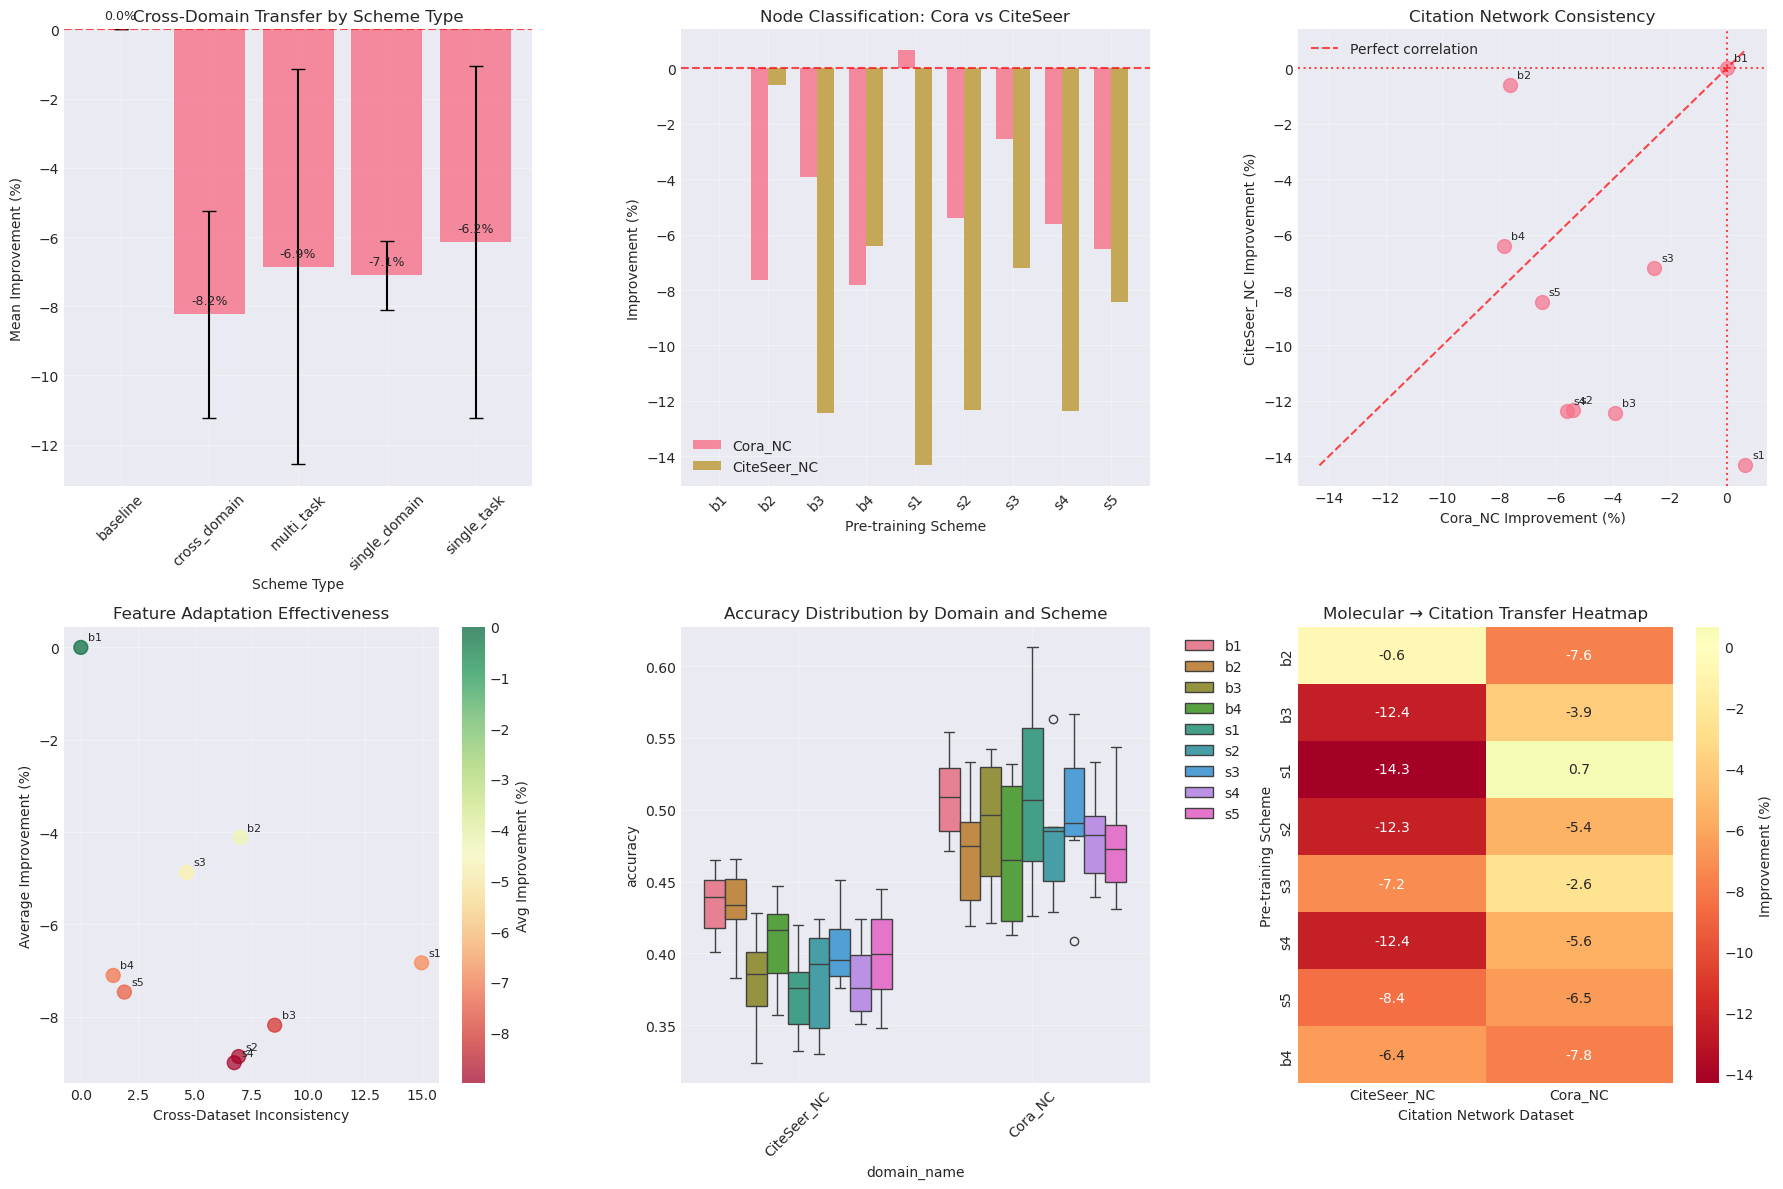

Node classification visualization saved to: analysis/figures/node_classification_transfer.png


In [23]:
# Create comprehensive visualizations for node classification analysis
if node_scheme_df is not None and node_raw is not None:
    print("Creating Node Classification Visualizations...")
    
    plt.figure(figsize=(18, 12))
    
    # 1. Cross-domain transfer effectiveness by scheme type
    plt.subplot(2, 3, 1)
    scheme_type_perf = node_scheme_df.groupby('scheme_type')['improvement_pct'].agg(['mean', 'std']).reset_index()
    
    bars = plt.bar(scheme_type_perf['scheme_type'], scheme_type_perf['mean'], 
                  yerr=scheme_type_perf['std'], capsize=5, alpha=0.8)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Scheme Type')
    plt.ylabel('Mean Improvement (%)')
    plt.title('Cross-Domain Transfer by Scheme Type')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, mean_val in zip(bars, scheme_type_perf['mean']):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.2,
                f'{mean_val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 2. Performance comparison by scheme (Cora vs CiteSeer)
    plt.subplot(2, 3, 2)
    if node_pivot_improvement is not None:
        schemes = node_pivot_improvement.index
        x_pos = np.arange(len(schemes))
        width = 0.35
        
        cora_data = node_pivot_improvement['Cora_NC'].fillna(0)
        citeseer_data = node_pivot_improvement['CiteSeer_NC'].fillna(0)
        
        bars1 = plt.bar(x_pos - width/2, cora_data, width, label='Cora_NC', alpha=0.8)
        bars2 = plt.bar(x_pos + width/2, citeseer_data, width, label='CiteSeer_NC', alpha=0.8)
        
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.xlabel('Pre-training Scheme')
        plt.ylabel('Improvement (%)')
        plt.title('Node Classification: Cora vs CiteSeer')
        plt.xticks(x_pos, schemes, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 3. Cross-domain correlation scatter plot
    plt.subplot(2, 3, 3)
    if node_pivot_improvement is not None and 'Cora_NC' in node_pivot_improvement.columns and 'CiteSeer_NC' in node_pivot_improvement.columns:
        valid_node_data = node_pivot_improvement.dropna()
        if not valid_node_data.empty:
            plt.scatter(valid_node_data['Cora_NC'], valid_node_data['CiteSeer_NC'], alpha=0.7, s=100)
            
            # Add labels for each point
            for idx, scheme in enumerate(valid_node_data.index):
                plt.annotate(scheme, (valid_node_data.loc[scheme, 'Cora_NC'], valid_node_data.loc[scheme, 'CiteSeer_NC']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
            
            # Add diagonal line
            min_val = min(valid_node_data.min())
            max_val = max(valid_node_data.max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect correlation')
            
            plt.axhline(y=0, color='red', linestyle=':', alpha=0.7)
            plt.axvline(x=0, color='red', linestyle=':', alpha=0.7)
            plt.xlabel('Cora_NC Improvement (%)')
            plt.ylabel('CiteSeer_NC Improvement (%)')
            plt.title('Citation Network Consistency')
            plt.legend()
            plt.grid(True, alpha=0.3)
    
    # 4. Feature dimensionality impact analysis
    plt.subplot(2, 3, 4)
    # Compare schemes by their ability to handle feature dimension mismatch
    feature_impact_data = []
    for scheme in node_scheme_df['scheme'].unique():
        scheme_data = node_scheme_df[node_scheme_df['scheme'] == scheme]
        if len(scheme_data) >= 2:  # Both domains available
            cora_imp = scheme_data[scheme_data['domain'] == 'Cora_NC']['improvement_pct'].iloc[0]
            citeseer_imp = scheme_data[scheme_data['domain'] == 'CiteSeer_NC']['improvement_pct'].iloc[0]
            avg_imp = (cora_imp + citeseer_imp) / 2
            consistency = abs(cora_imp - citeseer_imp)  # Lower is better
            
            feature_impact_data.append({
                'scheme': scheme,
                'avg_improvement': avg_imp,
                'consistency': consistency,
                'cora_improvement': cora_imp,
                'citeseer_improvement': citeseer_imp
            })
    
    if feature_impact_data:
        feature_df = pd.DataFrame(feature_impact_data)
        scatter = plt.scatter(feature_df['consistency'], feature_df['avg_improvement'], 
                            c=feature_df['avg_improvement'], cmap='RdYlGn', alpha=0.7, s=100)
        
        # Add labels
        for idx, row in feature_df.iterrows():
            plt.annotate(row['scheme'], (row['consistency'], row['avg_improvement']),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        plt.xlabel('Cross-Dataset Inconsistency')
        plt.ylabel('Average Improvement (%)')
        plt.title('Feature Adaptation Effectiveness')
        plt.colorbar(scatter, label='Avg Improvement (%)')
        plt.grid(True, alpha=0.3)
    
    # 5. Box plot by scheme type
    plt.subplot(2, 3, 5)
    node_raw_plot = node_raw.copy()
    sns.boxplot(data=node_raw_plot, x='domain_name', y='accuracy', hue='pretrained_scheme')
    plt.xticks(rotation=45)
    plt.title('Accuracy Distribution by Domain and Scheme')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # 6. Molecular → Citation transfer heatmap
    plt.subplot(2, 3, 6)
    # Create a heatmap showing transfer effectiveness
    if node_pivot_improvement is not None:
        # Focus on schemes that involve molecular pre-training
        molecular_schemes = ['b2', 'b3', 's1', 's2', 's3', 's4', 's5', 'b4']  # Exclude b1 (baseline)
        transfer_matrix = node_pivot_improvement.loc[molecular_schemes]
        
        sns.heatmap(transfer_matrix, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
                   cbar_kws={'label': 'Improvement (%)'})
        plt.title('Molecular → Citation Transfer Heatmap')
        plt.xlabel('Citation Network Dataset')
        plt.ylabel('Pre-training Scheme')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'node_classification_transfer.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Node classification visualization saved to: analysis/figures/node_classification_transfer.png")
    
else:
    print("Cannot create visualizations without data. Please ensure previous steps completed successfully.")


## Node Classification Summary and Insights


In [24]:
# Generate summary and insights for node classification
if node_scheme_df is not None:
    print("=" * 60)
    print("NODE CLASSIFICATION SUMMARY AND INSIGHTS")
    print("=" * 60)
    
    # Key findings
    print("\nKEY FINDINGS:")
    
    # Best overall schemes for cross-domain transfer
    overall_node_improvement = node_scheme_df.groupby('scheme')['improvement_pct'].mean().sort_values(ascending=False)
    print(f"\n1. BEST PERFORMING SCHEMES FOR MOLECULAR → CITATION TRANSFER:")
    for i, (scheme, improvement) in enumerate(overall_node_improvement.head(3).items()):
        scheme_type = node_scheme_df[node_scheme_df['scheme'] == scheme]['scheme_type'].iloc[0]
        print(f"   {i+1}. {scheme} ({scheme_type}): {improvement:.2f}%")
    
    # Cross-domain transfer effectiveness
    cross_domain_schemes = node_scheme_df[node_scheme_df['cross_domain_transfer'] == True]
    single_domain_schemes = node_scheme_df[node_scheme_df['cross_domain_transfer'] == False]
    
    if not cross_domain_schemes.empty and not single_domain_schemes.empty:
        cross_avg = cross_domain_schemes['improvement_pct'].mean()
        single_avg = single_domain_schemes['improvement_pct'].mean()
        print(f"\n2. CROSS-DOMAIN TRANSFER EFFECTIVENESS:")
        print(f"   - Cross-domain schemes: {cross_avg:.2f}% average improvement")
        print(f"   - Single-domain schemes: {single_avg:.2f}% average improvement")
        print(f"   - Cross-domain advantage: {cross_avg - single_avg:.2f}%")
    
    # Feature dimensionality impact
    print(f"\n3. FEATURE DIMENSIONALITY IMPACT:")
    print(f"   Challenge: Molecular (4-37 features) → Citation networks (1433-3703 features)")
    
    # Best schemes for handling feature mismatch
    if node_pivot_improvement is not None and len(node_pivot_improvement.columns) >= 2:
        valid_node_data = node_pivot_improvement.dropna()
        if len(valid_node_data) > 1:
            # Calculate consistency (lower variance = better at handling feature mismatch)
            feature_consistency = valid_node_data.std(axis=1).sort_values()
            most_consistent = feature_consistency.head(3)
            
            print(f"   Most consistent across feature dimensions:")
            for scheme, consistency in most_consistent.items():
                avg_improvement = valid_node_data.loc[scheme].mean()
                print(f"     {scheme}: {avg_improvement:.2f}% avg, {consistency:.2f} consistency")
    
    # Dataset-specific insights
    print(f"\n4. DATASET-SPECIFIC INSIGHTS:")
    for domain in node_class_domains:
        domain_data = node_scheme_df[node_scheme_df['domain'] == domain]
        if not domain_data.empty:
            best = domain_data.loc[domain_data['improvement_pct'].idxmax()]
            worst = domain_data.loc[domain_data['improvement_pct'].idxmin()]
            print(f"   {domain}:")
            print(f"     - Best: {best['scheme']} (+{best['improvement_pct']:.2f}%)")
            print(f"     - Worst: {worst['scheme']} ({worst['improvement_pct']:.2f}%)")
            print(f"     - Transfer challenge: {'High' if abs(best['improvement_pct']) > 5 else 'Moderate' if abs(best['improvement_pct']) > 1 else 'Low'}")
    
    # Citation network consistency
    if node_pivot_improvement is not None and len(node_pivot_improvement.columns) >= 2:
        valid_node_data = node_pivot_improvement.dropna()
        if len(valid_node_data) > 1:
            corr_coef = np.corrcoef(valid_node_data.iloc[:, 0], valid_node_data.iloc[:, 1])[0, 1]
            print(f"\n5. CITATION NETWORK CONSISTENCY:")
            print(f"   - Performance correlation: {corr_coef:.3f}")
            print(f"   - Consistency level: {'High' if abs(corr_coef) > 0.7 else 'Moderate' if abs(corr_coef) > 0.4 else 'Low'}")
    
    # Scheme type analysis
    scheme_type_performance = node_scheme_df.groupby('scheme_type')['improvement_pct'].mean().sort_values(ascending=False)
    print(f"\n6. SCHEME TYPE EFFECTIVENESS:")
    for scheme_type, improvement in scheme_type_performance.items():
        if scheme_type != 'baseline':  # Skip baseline
            count = len(node_scheme_df[node_scheme_df['scheme_type'] == scheme_type])
            print(f"   - {scheme_type}: {improvement:.2f}% ({count} combinations)")
    
    # Recommendations
    print(f"\n7. RECOMMENDATIONS FOR NODE CLASSIFICATION:")
    
    # Top schemes for cross-domain transfer
    top_3_node_schemes = overall_node_improvement.head(3).index.tolist()
    print(f"   - Recommended schemes for molecular → citation transfer: {', '.join(top_3_node_schemes)}")
    
    # Best strategy for handling feature dimensionality gaps
    if node_pivot_improvement is not None:
        # Find schemes that work well on both datasets (good feature adaptation)
        valid_data = node_pivot_improvement.dropna()
        if not valid_data.empty:
            min_performance = valid_data.min(axis=1)  # Worst performance across datasets
            robust_schemes = min_performance.sort_values(ascending=False).head(2)
            print(f"   - Most robust to feature dimensionality: {', '.join(robust_schemes.index)}")
    
    # Domain-specific recommendations
    cora_best = node_scheme_df[node_scheme_df['domain'] == 'Cora_NC'].loc[node_scheme_df[node_scheme_df['domain'] == 'Cora_NC']['improvement_pct'].idxmax(), 'scheme']
    citeseer_best = node_scheme_df[node_scheme_df['domain'] == 'CiteSeer_NC'].loc[node_scheme_df[node_scheme_df['domain'] == 'CiteSeer_NC']['improvement_pct'].idxmax(), 'scheme']
    
    print(f"   - For Cora-like citation networks: Use {cora_best}")
    print(f"   - For CiteSeer-like citation networks: Use {citeseer_best}")
    
    # Cross-domain vs single-domain recommendation
    if not cross_domain_schemes.empty and not single_domain_schemes.empty:
        if cross_avg > single_avg:
            print(f"   - Cross-domain pre-training recommended ({cross_avg - single_avg:.2f}% advantage)")
        else:
            print(f"   - Single-domain pre-training may be sufficient ({single_avg - cross_avg:.2f}% advantage)")
    
    print(f"\nCHALLENGES IDENTIFIED:")
    print(f"   - Large feature dimensionality gap (10-100x difference)")
    print(f"   - Domain shift: molecular graphs → citation networks")
    print(f"   - Limited improvement suggests challenging transfer learning scenario")
    
    print(f"\nAnalysis complete! Results saved to: analysis/results/node_classification_analysis.csv")
    
else:
    print("Cannot generate insights without completed analysis.")


NODE CLASSIFICATION SUMMARY AND INSIGHTS

KEY FINDINGS:

1. BEST PERFORMING SCHEMES FOR MOLECULAR → CITATION TRANSFER:
   1. b1 (baseline): 0.00%
   2. b2 (single_task): -4.12%
   3. s3 (multi_task): -4.88%

2. CROSS-DOMAIN TRANSFER EFFECTIVENESS:
   - Cross-domain schemes: -7.41% average improvement
   - Single-domain schemes: -4.85% average improvement
   - Cross-domain advantage: -2.56%

3. FEATURE DIMENSIONALITY IMPACT:
   Challenge: Molecular (4-37 features) → Citation networks (1433-3703 features)
   Most consistent across feature dimensions:
     b1: 0.00% avg, 0.00 consistency
     b4: -7.11% avg, 1.01 consistency
     s5: -7.47% avg, 1.35 consistency

4. DATASET-SPECIFIC INSIGHTS:
   Cora_NC:
     - Best: s1 (+0.65%)
     - Worst: b4 (-7.82%)
     - Transfer challenge: Low
   CiteSeer_NC:
     - Best: b1 (+0.00%)
     - Worst: s1 (-14.32%)
     - Transfer challenge: Low

5. CITATION NETWORK CONSISTENCY:
   - Performance correlation: -0.122
   - Consistency level: Low

6. SCHEM

---

## Step 3.3: Link Prediction Analysis

**Focus:** Deep analysis of link prediction performance (Cora_LP, CiteSeer_LP)

**Objectives:**
- Extract and analyze Cora_LP and CiteSeer_LP results
- Analyze effectiveness of link prediction pre-training (present in s1, s3, s4, s5, b4)
- Compare performance between citation network datasets
- Investigate structural learning transfer patterns

**Key Insights to Explore:**
- Impact of link prediction as a pre-training task
- Structural pattern transfer from molecular to citation networks
- Graph structure similarity analysis between domains
- AUC performance patterns and structural learning effectiveness

**Pre-training Schemes with Link Prediction:**
- s1: Generative (includes link prediction)
- s3: Combined 4-task (includes link prediction)
- s4: All 5 tasks cross-domain (includes link prediction)
- s5: All 5 tasks + domain adversarial (includes link prediction)
- b4: All 5 tasks single-domain (includes link prediction)


## Link Prediction Data Extraction and Overview


In [25]:
# Extract link prediction data
if agg_df is not None:
    # Filter for link prediction tasks
    link_pred_domains = ['Cora_LP', 'CiteSeer_LP']
    link_agg = agg_df[agg_df['domain_name'].isin(link_pred_domains)].copy()
    link_raw = raw_df[raw_df['domain_name'].isin(link_pred_domains)].copy()
    
    print("=" * 60)
    print("LINK PREDICTION DATA OVERVIEW")
    print("=" * 60)
    
    # Basic statistics
    print(f"\nDataset Characteristics:")
    for domain in link_pred_domains:
        domain_data = link_agg[link_agg['domain_name'] == domain]
        if not domain_data.empty:
            task_type = domain_data['task_type'].iloc[0]
            num_combinations = len(domain_data)
            print(f"  {domain}:")
            print(f"    - Task type: {task_type}")
            print(f"    - Combinations available: {num_combinations}")
            print(f"    - Schemes: {sorted(domain_data['pretrained_scheme'].unique())}")
            print(f"    - Strategies: {sorted(domain_data['finetune_strategy'].unique())}")
    
    # Performance overview (AUC is primary metric for link prediction)
    print(f"\nPerformance Overview (AUC):")
    for domain in link_pred_domains:
        domain_data = link_agg[link_agg['domain_name'] == domain]
        if not domain_data.empty:
            auc_stats = domain_data['auc_mean'].describe()
            print(f"\n  {domain} AUC Statistics:")
            print(f"    - Mean: {auc_stats['mean']:.4f}")
            print(f"    - Std: {auc_stats['std']:.4f}")
            print(f"    - Min: {auc_stats['min']:.4f}")
            print(f"    - Max: {auc_stats['max']:.4f}")
            
            # Best performing combination
            best_idx = domain_data['auc_mean'].idxmax()
            best_combo = domain_data.loc[best_idx]
            print(f"    - Best: {best_combo['pretrained_scheme']}-{best_combo['finetune_strategy']} ({best_combo['auc_mean']:.4f})")
    
    # Link prediction pre-training schemes analysis
    schemes_with_lp = ['s1', 's3', 's4', 's5', 'b4']  # Schemes that include link prediction in pre-training
    schemes_without_lp = ['b1', 'b2', 'b3', 's2']      # Schemes without link prediction
    
    print(f"\nLink Prediction Pre-training Analysis:")
    print(f"  Schemes WITH link prediction pre-training: {schemes_with_lp}")
    print(f"  Schemes WITHOUT link prediction pre-training: {schemes_without_lp}")
    
    # Compare performance of schemes with vs without LP pre-training
    for domain in link_pred_domains:
        domain_data = link_agg[link_agg['domain_name'] == domain]
        if not domain_data.empty:
            with_lp_data = domain_data[domain_data['pretrained_scheme'].isin(schemes_with_lp)]
            without_lp_data = domain_data[domain_data['pretrained_scheme'].isin(schemes_without_lp)]
            
            if not with_lp_data.empty and not without_lp_data.empty:
                with_lp_mean = with_lp_data['auc_mean'].mean()
                without_lp_mean = without_lp_data['auc_mean'].mean()
                lp_advantage = with_lp_mean - without_lp_mean
                
                print(f"\n  {domain} LP Pre-training Impact:")
                print(f"    - With LP pre-training: {with_lp_mean:.4f} AUC")
                print(f"    - Without LP pre-training: {without_lp_mean:.4f} AUC")
                print(f"    - LP pre-training advantage: {lp_advantage:.4f} AUC ({lp_advantage/without_lp_mean*100:.2f}%)")
    
    # Task characteristics comparison
    print(f"\nTask Characteristics Analysis:")
    print(f"  Key Features:")
    print(f"    - Cora_LP: Citation network link prediction")
    print(f"    - CiteSeer_LP: Citation network link prediction") 
    print(f"    - Both: Structural learning on academic citation networks")
    print(f"    - Challenge: Transfer structural patterns from molecular to citation graphs")
    print(f"    - Metric: AUC (Area Under ROC Curve) - measures ranking quality")
    
else:
    print("Cannot perform analysis without data. Please run previous steps first.")
    link_agg = link_raw = None


LINK PREDICTION DATA OVERVIEW

Dataset Characteristics:
  Cora_LP:
    - Task type: link_prediction
    - Combinations available: 18
    - Schemes: ['b1', 'b2', 'b3', 'b4', 's1', 's2', 's3', 's4', 's5']
    - Strategies: ['full_finetune', 'linear_probe']
  CiteSeer_LP:
    - Task type: link_prediction
    - Combinations available: 18
    - Schemes: ['b1', 'b2', 'b3', 'b4', 's1', 's2', 's3', 's4', 's5']
    - Strategies: ['full_finetune', 'linear_probe']

Performance Overview (AUC):

  Cora_LP AUC Statistics:
    - Mean: 0.0828
    - Std: 0.0030
    - Min: 0.0769
    - Max: 0.0872
    - Best: b1-full_finetune (0.0872)

  CiteSeer_LP AUC Statistics:
    - Mean: 0.0969
    - Std: 0.0083
    - Min: 0.0814
    - Max: 0.1131
    - Best: b3-linear_probe (0.1131)

Link Prediction Pre-training Analysis:
  Schemes WITH link prediction pre-training: ['s1', 's3', 's4', 's5', 'b4']
  Schemes WITHOUT link prediction pre-training: ['b1', 'b2', 'b3', 's2']

  Cora_LP LP Pre-training Impact:
    - With

## Link Prediction Pre-training Effectiveness Analysis


In [26]:
# Analyze link prediction pre-training effectiveness
if link_agg is not None:
    print("=" * 60)
    print("LINK PREDICTION PRE-TRAINING EFFECTIVENESS ANALYSIS")
    print("=" * 60)
    
    # Calculate baseline performance for each domain
    link_baseline_performance = {}
    for domain in link_pred_domains:
        baseline_data = link_agg[
            (link_agg['domain_name'] == domain) & 
            (link_agg['pretrained_scheme'] == 'b1')
        ]
        if not baseline_data.empty:
            link_baseline_performance[domain] = baseline_data['auc_mean'].mean()
    
    print(f"\nBaseline Performance (b1 - from scratch):")
    for domain, perf in link_baseline_performance.items():
        print(f"  {domain}: {perf:.4f} AUC")
    
    # Analyze scheme performance with focus on link prediction pre-training
    link_scheme_analysis = []
    schemes = sorted(link_agg['pretrained_scheme'].unique())
    schemes_with_lp = ['s1', 's3', 's4', 's5', 'b4']
    
    for domain in link_pred_domains:
        if domain not in link_baseline_performance:
            continue
            
        baseline_perf = link_baseline_performance[domain]
        domain_data = link_agg[link_agg['domain_name'] == domain]
        
        for scheme in schemes:
            scheme_data = domain_data[domain_data['pretrained_scheme'] == scheme]
            if not scheme_data.empty:
                mean_auc = scheme_data['auc_mean'].mean()
                std_auc = scheme_data['auc_mean'].std()
                improvement = ((mean_auc - baseline_perf) / baseline_perf) * 100
                
                # Calculate rank within domain
                domain_scheme_means = domain_data.groupby('pretrained_scheme')['auc_mean'].mean()
                rank = domain_scheme_means.rank(ascending=False)[scheme]
                
                # Classify by link prediction pre-training
                has_lp_pretraining = scheme in schemes_with_lp
                
                # Classify scheme type for structural analysis
                if scheme == 'b1':
                    scheme_type = 'baseline'
                elif scheme in ['b2', 'b3']:
                    scheme_type = 'single_task_no_lp'
                elif scheme == 's2':
                    scheme_type = 'contrastive_no_lp'
                elif scheme == 'b4':
                    scheme_type = 'single_domain_with_lp'
                elif scheme in ['s1', 's3', 's4', 's5']:
                    scheme_type = 'multi_task_with_lp'
                else:
                    scheme_type = 'other'
                
                link_scheme_analysis.append({
                    'domain': domain,
                    'scheme': scheme,
                    'scheme_type': scheme_type,
                    'has_lp_pretraining': has_lp_pretraining,
                    'mean_auc': mean_auc,
                    'std_auc': std_auc,
                    'improvement_pct': improvement,
                    'rank_in_domain': rank,
                    'num_combinations': len(scheme_data)
                })
    
    link_scheme_df = pd.DataFrame(link_scheme_analysis)
    
    print(f"\nLink Prediction Scheme Performance Analysis:")
    print(link_scheme_df.round(4))
    
    # Link prediction pre-training effectiveness analysis
    print(f"\nLink Prediction Pre-training Effectiveness:")
    
    # Compare schemes with vs without LP pre-training
    with_lp_schemes = link_scheme_df[link_scheme_df['has_lp_pretraining'] == True]
    without_lp_schemes = link_scheme_df[link_scheme_df['has_lp_pretraining'] == False]
    
    if not with_lp_schemes.empty and not without_lp_schemes.empty:
        with_lp_avg = with_lp_schemes['improvement_pct'].mean()
        without_lp_avg = without_lp_schemes['improvement_pct'].mean()
        lp_pretraining_advantage = with_lp_avg - without_lp_avg
        
        print(f"  Schemes WITH LP pre-training: {with_lp_avg:.2f}% average improvement")
        print(f"  Schemes WITHOUT LP pre-training: {without_lp_avg:.2f}% average improvement")
        print(f"  LP pre-training advantage: {lp_pretraining_advantage:.2f}%")
        print(f"  LP pre-training {'helps' if lp_pretraining_advantage > 0 else 'hurts'} link prediction performance")
    
    # Best schemes with LP pre-training
    if not with_lp_schemes.empty:
        best_lp_schemes = with_lp_schemes.groupby('scheme')['improvement_pct'].mean().sort_values(ascending=False)
        print(f"\n  Best LP pre-training schemes:")
        for scheme, improvement in best_lp_schemes.head(3).items():
            print(f"    {scheme}: {improvement:.2f}% average improvement")
    
    # Structural learning transfer analysis
    print(f"\nStructural Learning Transfer Analysis:")
    print(f"  Challenge: Molecular graph structures → Citation network structures")
    
    # Analyze how well different scheme types handle structural transfer
    scheme_type_performance = link_scheme_df.groupby('scheme_type')['improvement_pct'].agg(['mean', 'std', 'count']).round(3)
    print(f"\n  Scheme Type Performance:")
    print(scheme_type_performance)
    
    # Best scheme type for structural transfer
    best_scheme_type = scheme_type_performance['mean'].idxmax()
    best_type_improvement = scheme_type_performance.loc[best_scheme_type, 'mean']
    print(f"\n  Best scheme type for structural transfer: {best_scheme_type} ({best_type_improvement:.2f}% avg improvement)")
    
else:
    link_scheme_df = None


LINK PREDICTION PRE-TRAINING EFFECTIVENESS ANALYSIS

Baseline Performance (b1 - from scratch):
  Cora_LP: 0.0846 AUC
  CiteSeer_LP: 0.0950 AUC

Link Prediction Scheme Performance Analysis:
         domain scheme            scheme_type  has_lp_pretraining  mean_auc  \
0       Cora_LP     b1               baseline               False    0.0846   
1       Cora_LP     b2      single_task_no_lp               False    0.0846   
2       Cora_LP     b3      single_task_no_lp               False    0.0844   
3       Cora_LP     b4  single_domain_with_lp                True    0.0842   
4       Cora_LP     s1     multi_task_with_lp                True    0.0770   
5       Cora_LP     s2      contrastive_no_lp               False    0.0833   
6       Cora_LP     s3     multi_task_with_lp                True    0.0843   
7       Cora_LP     s4     multi_task_with_lp                True    0.0825   
8       Cora_LP     s5     multi_task_with_lp                True    0.0800   
9   CiteSeer_LP     b

## Structural Transfer and AUC Performance Patterns


In [27]:
# Analyze structural transfer patterns and AUC performance consistency
if link_scheme_df is not None:
    print("=" * 60)
    print("STRUCTURAL TRANSFER AND AUC PERFORMANCE PATTERNS")
    print("=" * 60)
    
    # Create pivot table for easier comparison
    link_pivot_improvement = link_scheme_df.pivot(index='scheme', columns='domain', values='improvement_pct')
    link_pivot_rank = link_scheme_df.pivot(index='scheme', columns='domain', values='rank_in_domain')
    link_pivot_auc = link_scheme_df.pivot(index='scheme', columns='domain', values='mean_auc')
    
    print(f"\nAUC Performance by Scheme:")
    print(link_pivot_auc.round(4))
    
    print(f"\nImprovement Percentage by Scheme:")
    print(link_pivot_improvement.round(2))
    
    print(f"\nRank by Scheme (1 = best):")
    print(link_pivot_rank.round(0))
    
    # Calculate correlation between datasets
    if 'Cora_LP' in link_pivot_improvement.columns and 'CiteSeer_LP' in link_pivot_improvement.columns:
        # Remove NaN values for correlation calculation
        valid_link_data = link_pivot_improvement.dropna()
        
        if len(valid_link_data) > 1:
            # Performance correlation
            link_perf_corr, link_perf_p = spearmanr(valid_link_data['Cora_LP'], valid_link_data['CiteSeer_LP'])
            print(f"\nStructural Transfer Consistency Between Citation Networks:")
            print(f"  Performance correlation: {link_perf_corr:.3f} (p={link_perf_p:.3f})")
            
            # Rank correlation
            valid_link_ranks = link_pivot_rank.dropna()
            if len(valid_link_ranks) > 1:
                link_rank_corr, link_rank_p = spearmanr(valid_link_ranks['Cora_LP'], valid_link_ranks['CiteSeer_LP'])
                print(f"  Rank correlation: {link_rank_corr:.3f} (p={link_rank_p:.3f})")
            
            # AUC correlation
            valid_link_auc = link_pivot_auc.dropna()
            if len(valid_link_auc) > 1:
                link_auc_corr, link_auc_p = spearmanr(valid_link_auc['Cora_LP'], valid_link_auc['CiteSeer_LP'])
                print(f"  AUC correlation: {link_auc_corr:.3f} (p={link_auc_p:.3f})")
            
            # Identify consistent performers
            print(f"\nConsistent Top Performers (top 3 in both datasets):")
            cora_lp_top3 = valid_link_ranks['Cora_LP'].nsmallest(3).index
            citeseer_lp_top3 = valid_link_ranks['CiteSeer_LP'].nsmallest(3).index
            consistent_link_top = set(cora_lp_top3) & set(citeseer_lp_top3)
            
            if consistent_link_top:
                for scheme in consistent_link_top:
                    c_rank = valid_link_ranks.loc[scheme, 'Cora_LP']
                    cs_rank = valid_link_ranks.loc[scheme, 'CiteSeer_LP']
                    c_imp = valid_link_data.loc[scheme, 'Cora_LP']
                    cs_imp = valid_link_data.loc[scheme, 'CiteSeer_LP']
                    c_auc = valid_link_auc.loc[scheme, 'Cora_LP']
                    cs_auc = valid_link_auc.loc[scheme, 'CiteSeer_LP']
                    print(f"  {scheme}: Cora rank {c_rank:.0f} ({c_auc:.3f} AUC, +{c_imp:.2f}%), CiteSeer rank {cs_rank:.0f} ({cs_auc:.3f} AUC, +{cs_imp:.2f}%)")
            else:
                print(f"  No schemes consistently in top 3 for both citation networks")
    
    # Link prediction pre-training impact analysis
    print(f"\nLink Prediction Pre-training Impact Analysis:")
    
    # Group by has_lp_pretraining
    lp_impact_analysis = link_scheme_df.groupby('has_lp_pretraining').agg({
        'improvement_pct': ['mean', 'std', 'count'],
        'mean_auc': ['mean', 'std'],
        'rank_in_domain': 'mean'
    }).round(3)
    lp_impact_analysis.columns = ['_'.join(col).strip() for col in lp_impact_analysis.columns]
    print(lp_impact_analysis)
    
    # Structural learning effectiveness by scheme type
    print(f"\nStructural Learning Effectiveness by Scheme Type:")
    structural_effectiveness = link_scheme_df.groupby('scheme_type').agg({
        'improvement_pct': ['mean', 'std'],
        'mean_auc': ['mean', 'std'],
        'rank_in_domain': 'mean'
    }).round(3)
    structural_effectiveness.columns = ['_'.join(col).strip() for col in structural_effectiveness.columns]
    print(structural_effectiveness)
    
    # Best structural transfer patterns
    print(f"\nBest Structural Transfer Patterns:")
    
    # Find schemes that work well across both datasets
    if not valid_link_data.empty:
        # Calculate average performance and consistency
        avg_performance = valid_link_data.mean(axis=1)
        consistency = -valid_link_data.std(axis=1)  # Negative because lower std is better
        
        # Combined score (weighted average performance and consistency)
        combined_score = 0.7 * avg_performance + 0.3 * consistency
        best_combined = combined_score.sort_values(ascending=False)
        
        print(f"  Best overall structural transfer (performance + consistency):")
        for scheme, score in best_combined.head(3).items():
            avg_imp = avg_performance[scheme]
            std_imp = -consistency[scheme]
            print(f"    {scheme}: {avg_imp:.2f}% avg improvement, {std_imp:.2f}% consistency")
    
    # Save the analysis results
    link_scheme_df.to_csv(RESULTS_DIR / 'link_prediction_analysis.csv', index=False)
    print(f"\nAnalysis saved to: {RESULTS_DIR / 'link_prediction_analysis.csv'}")
    
else:
    link_pivot_improvement = link_pivot_rank = link_pivot_auc = None


STRUCTURAL TRANSFER AND AUC PERFORMANCE PATTERNS

AUC Performance by Scheme:
domain  CiteSeer_LP  Cora_LP
scheme                      
b1           0.0950   0.0846
b2           0.0995   0.0846
b3           0.1018   0.0844
b4           0.0929   0.0842
s1           0.0939   0.0770
s2           0.1037   0.0833
s3           0.0962   0.0843
s4           0.0954   0.0825
s5           0.0934   0.0800

Improvement Percentage by Scheme:
domain  CiteSeer_LP  Cora_LP
scheme                      
b1             0.00     0.00
b2             4.72    -0.01
b3             7.17    -0.20
b4            -2.14    -0.50
s1            -1.12    -9.02
s2             9.17    -1.50
s3             1.30    -0.29
s4             0.45    -2.52
s5            -1.68    -5.42

Rank by Scheme (1 = best):
domain  CiteSeer_LP  Cora_LP
scheme                      
b1              6.0      1.0
b2              3.0      2.0
b3              2.0      3.0
b4              9.0      5.0
s1              7.0      9.0
s2              1.0

## Link Prediction Visualizations


Creating Link Prediction Visualizations...


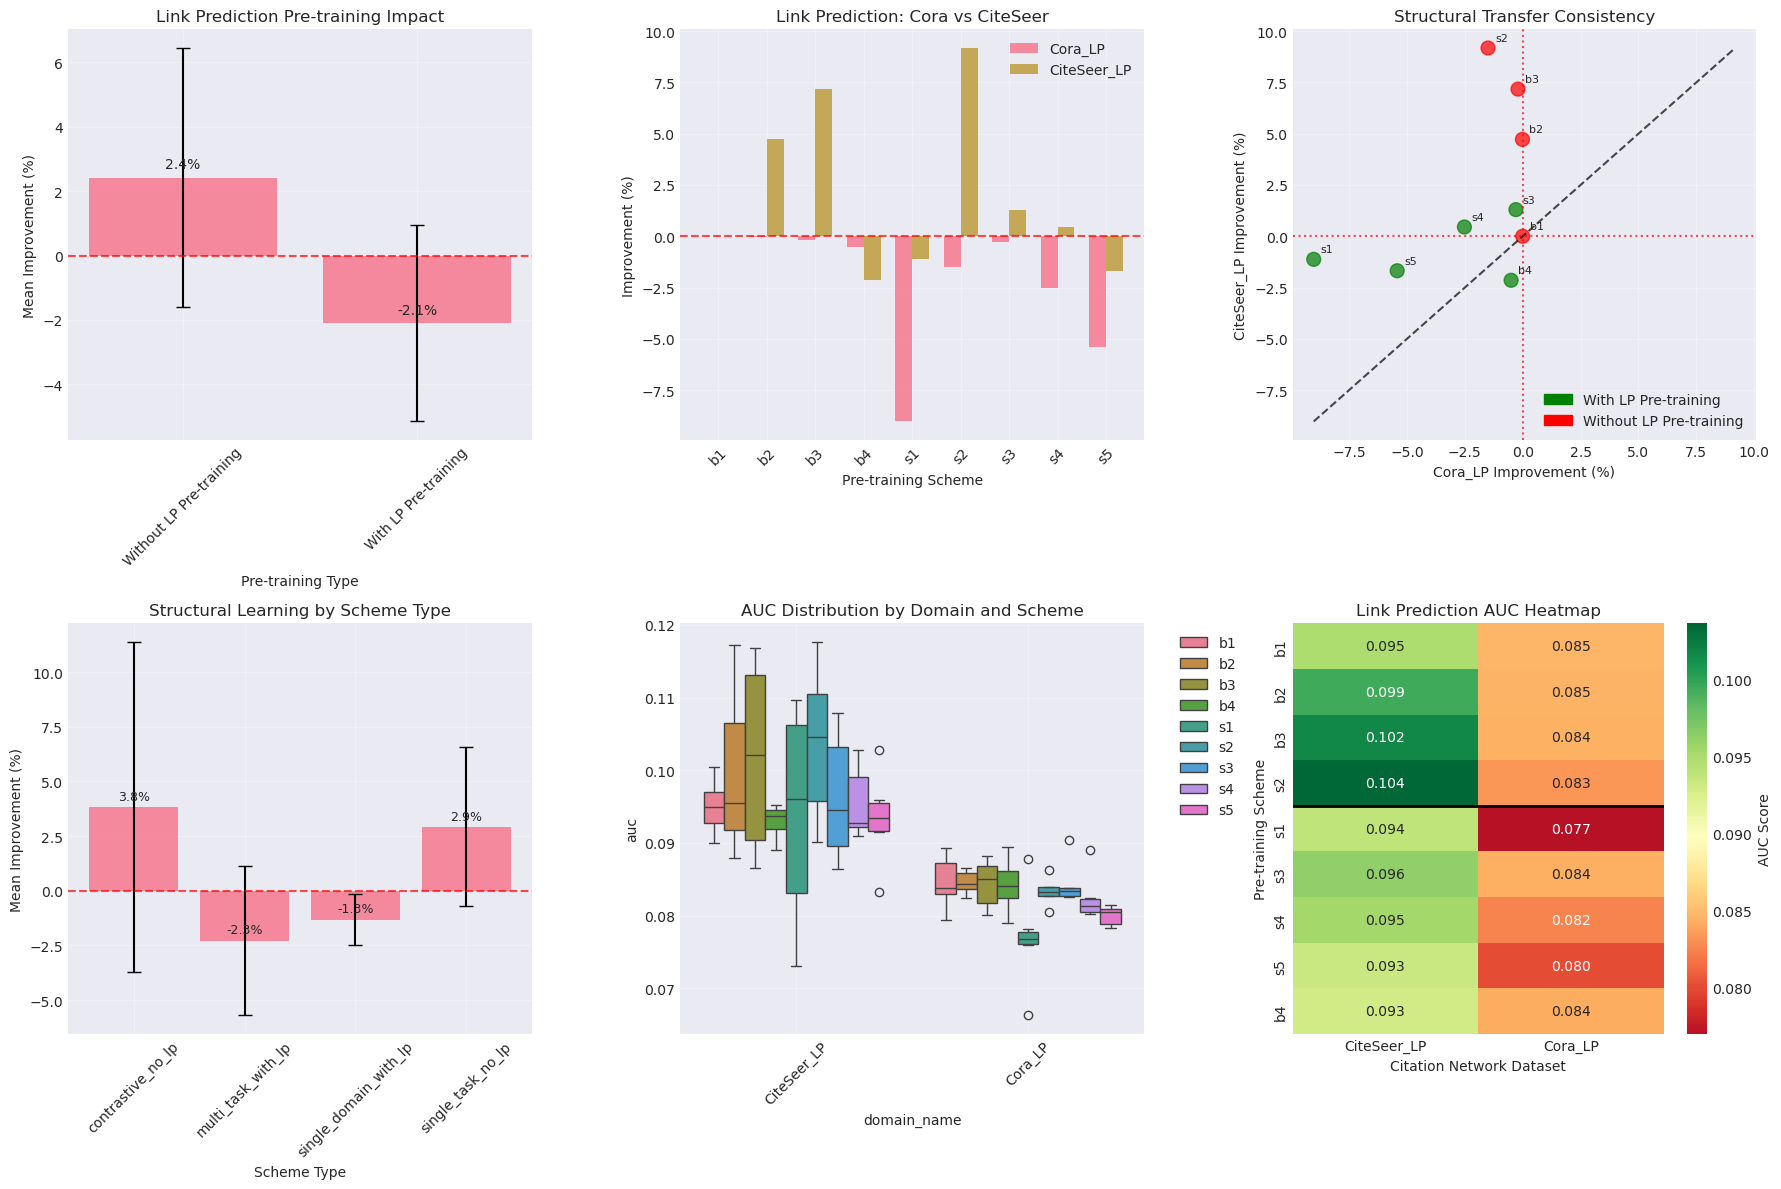

Link prediction visualization saved to: analysis/figures/link_prediction_effectiveness.png


In [28]:
# Create comprehensive visualizations for link prediction analysis
if link_scheme_df is not None and link_raw is not None:
    print("Creating Link Prediction Visualizations...")
    
    plt.figure(figsize=(18, 12))
    
    # 1. Link prediction pre-training impact
    plt.subplot(2, 3, 1)
    lp_impact_summary = link_scheme_df.groupby('has_lp_pretraining')['improvement_pct'].agg(['mean', 'std']).reset_index()
    lp_impact_summary['has_lp_pretraining'] = lp_impact_summary['has_lp_pretraining'].map({True: 'With LP Pre-training', False: 'Without LP Pre-training'})
    
    bars = plt.bar(lp_impact_summary['has_lp_pretraining'], lp_impact_summary['mean'], 
                  yerr=lp_impact_summary['std'], capsize=5, alpha=0.8)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Pre-training Type')
    plt.ylabel('Mean Improvement (%)')
    plt.title('Link Prediction Pre-training Impact')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, mean_val in zip(bars, lp_impact_summary['mean']):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.2,
                f'{mean_val:.1f}%', ha='center', va='bottom', fontsize=10)
    
    # 2. AUC performance comparison by scheme (Cora vs CiteSeer)
    plt.subplot(2, 3, 2)
    if link_pivot_improvement is not None:
        schemes = link_pivot_improvement.index
        x_pos = np.arange(len(schemes))
        width = 0.35
        
        cora_data = link_pivot_improvement['Cora_LP'].fillna(0)
        citeseer_data = link_pivot_improvement['CiteSeer_LP'].fillna(0)
        
        bars1 = plt.bar(x_pos - width/2, cora_data, width, label='Cora_LP', alpha=0.8)
        bars2 = plt.bar(x_pos + width/2, citeseer_data, width, label='CiteSeer_LP', alpha=0.8)
        
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.xlabel('Pre-training Scheme')
        plt.ylabel('Improvement (%)')
        plt.title('Link Prediction: Cora vs CiteSeer')
        plt.xticks(x_pos, schemes, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 3. Structural transfer correlation scatter plot
    plt.subplot(2, 3, 3)
    if link_pivot_improvement is not None and 'Cora_LP' in link_pivot_improvement.columns and 'CiteSeer_LP' in link_pivot_improvement.columns:
        valid_link_data = link_pivot_improvement.dropna()
        if not valid_link_data.empty:
            # Color points by whether they have LP pre-training
            colors = []
            schemes_with_lp = ['s1', 's3', 's4', 's5', 'b4']
            for scheme in valid_link_data.index:
                colors.append('green' if scheme in schemes_with_lp else 'red')
            
            plt.scatter(valid_link_data['Cora_LP'], valid_link_data['CiteSeer_LP'], 
                       c=colors, alpha=0.7, s=100)
            
            # Add labels for each point
            for idx, scheme in enumerate(valid_link_data.index):
                plt.annotate(scheme, (valid_link_data.loc[scheme, 'Cora_LP'], valid_link_data.loc[scheme, 'CiteSeer_LP']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
            
            # Add diagonal line
            min_val = min(valid_link_data.min())
            max_val = max(valid_link_data.max())
            plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7, label='Perfect correlation')
            
            plt.axhline(y=0, color='red', linestyle=':', alpha=0.7)
            plt.axvline(x=0, color='red', linestyle=':', alpha=0.7)
            plt.xlabel('Cora_LP Improvement (%)')
            plt.ylabel('CiteSeer_LP Improvement (%)')
            plt.title('Structural Transfer Consistency')
            
            # Create legend for colors
            import matplotlib.patches as mpatches
            green_patch = mpatches.Patch(color='green', label='With LP Pre-training')
            red_patch = mpatches.Patch(color='red', label='Without LP Pre-training')
            plt.legend(handles=[green_patch, red_patch])
            plt.grid(True, alpha=0.3)
    
    # 4. Scheme type effectiveness
    plt.subplot(2, 3, 4)
    scheme_type_perf = link_scheme_df.groupby('scheme_type')['improvement_pct'].agg(['mean', 'std']).reset_index()
    scheme_type_perf = scheme_type_perf[scheme_type_perf['scheme_type'] != 'baseline']  # Exclude baseline
    
    bars = plt.bar(scheme_type_perf['scheme_type'], scheme_type_perf['mean'], 
                  yerr=scheme_type_perf['std'], capsize=5, alpha=0.8)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Scheme Type')
    plt.ylabel('Mean Improvement (%)')
    plt.title('Structural Learning by Scheme Type')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, mean_val in zip(bars, scheme_type_perf['mean']):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.2,
                f'{mean_val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 5. AUC distribution box plots
    plt.subplot(2, 3, 5)
    link_raw_plot = link_raw.copy()
    sns.boxplot(data=link_raw_plot, x='domain_name', y='auc', hue='pretrained_scheme')
    plt.xticks(rotation=45)
    plt.title('AUC Distribution by Domain and Scheme')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # 6. Link prediction effectiveness heatmap
    plt.subplot(2, 3, 6)
    if link_pivot_auc is not None:
        # Create heatmap showing AUC performance
        schemes_with_lp = ['s1', 's3', 's4', 's5', 'b4']
        schemes_without_lp = ['b1', 'b2', 'b3', 's2']
        
        # Separate schemes by LP pre-training for better visualization
        all_schemes = schemes_without_lp + schemes_with_lp
        available_schemes = [s for s in all_schemes if s in link_pivot_auc.index]
        
        if available_schemes:
            heatmap_data = link_pivot_auc.loc[available_schemes]
            
            # Create custom colormap centered around baseline performance
            baseline_auc = heatmap_data.loc['b1'].mean() if 'b1' in heatmap_data.index else heatmap_data.mean().mean()
            
            sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
                       center=baseline_auc, cbar_kws={'label': 'AUC Score'})
            plt.title('Link Prediction AUC Heatmap')
            plt.xlabel('Citation Network Dataset')
            plt.ylabel('Pre-training Scheme')
            
            # Add separator line between schemes with/without LP
            if len(schemes_without_lp) > 0 and len(schemes_with_lp) > 0:
                separator_pos = len([s for s in schemes_without_lp if s in available_schemes])
                if separator_pos > 0 and separator_pos < len(available_schemes):
                    plt.axhline(y=separator_pos, color='black', linewidth=2)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'link_prediction_effectiveness.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Link prediction visualization saved to: analysis/figures/link_prediction_effectiveness.png")
    
else:
    print("Cannot create visualizations without data. Please ensure previous steps completed successfully.")


## Link Prediction Summary and Insights


In [29]:
# Generate summary and insights for link prediction
if link_scheme_df is not None:
    print("=" * 60)
    print("LINK PREDICTION SUMMARY AND INSIGHTS")
    print("=" * 60)
    
    # Key findings
    print("\nKEY FINDINGS:")
    
    # Best overall schemes for link prediction
    overall_link_improvement = link_scheme_df.groupby('scheme')['improvement_pct'].mean().sort_values(ascending=False)
    print(f"\n1. BEST PERFORMING SCHEMES FOR LINK PREDICTION:")
    for i, (scheme, improvement) in enumerate(overall_link_improvement.head(3).items()):
        scheme_type = link_scheme_df[link_scheme_df['scheme'] == scheme]['scheme_type'].iloc[0]
        has_lp = link_scheme_df[link_scheme_df['scheme'] == scheme]['has_lp_pretraining'].iloc[0]
        lp_status = "with LP" if has_lp else "without LP"
        print(f"   {i+1}. {scheme} ({scheme_type}, {lp_status}): {improvement:.2f}%")
    
    # Link prediction pre-training effectiveness
    with_lp_schemes = link_scheme_df[link_scheme_df['has_lp_pretraining'] == True]
    without_lp_schemes = link_scheme_df[link_scheme_df['has_lp_pretraining'] == False]
    
    if not with_lp_schemes.empty and not without_lp_schemes.empty:
        with_lp_avg = with_lp_schemes['improvement_pct'].mean()
        without_lp_avg = without_lp_schemes['improvement_pct'].mean()
        lp_advantage = with_lp_avg - without_lp_avg
        
        print(f"\n2. LINK PREDICTION PRE-TRAINING EFFECTIVENESS:")
        print(f"   - Schemes WITH LP pre-training: {with_lp_avg:.2f}% average improvement")
        print(f"   - Schemes WITHOUT LP pre-training: {without_lp_avg:.2f}% average improvement")
        print(f"   - LP pre-training advantage: {lp_advantage:.2f}%")
        print(f"   - Conclusion: LP pre-training {'helps' if lp_advantage > 0 else 'hurts' if lp_advantage < -0.5 else 'has minimal impact on'} link prediction performance")
    
    # Structural learning transfer effectiveness
    print(f"\n3. STRUCTURAL LEARNING TRANSFER EFFECTIVENESS:")
    scheme_type_performance = link_scheme_df.groupby('scheme_type')['improvement_pct'].mean().sort_values(ascending=False)
    
    best_structural_type = scheme_type_performance.index[0] if len(scheme_type_performance) > 0 else None
    if best_structural_type and best_structural_type != 'baseline':
        best_structural_improvement = scheme_type_performance.iloc[0]
        print(f"   - Best scheme type for structural transfer: {best_structural_type} ({best_structural_improvement:.2f}%)")
    
    # Print all scheme types performance
    print(f"   - Scheme type rankings:")
    for scheme_type, improvement in scheme_type_performance.items():
        if scheme_type != 'baseline':
            count = len(link_scheme_df[link_scheme_df['scheme_type'] == scheme_type])
            print(f"     {scheme_type}: {improvement:.2f}% ({count} combinations)")
    
    # Dataset-specific insights
    print(f"\n4. DATASET-SPECIFIC INSIGHTS:")
    for domain in link_pred_domains:
        domain_data = link_scheme_df[link_scheme_df['domain'] == domain]
        if not domain_data.empty:
            best = domain_data.loc[domain_data['improvement_pct'].idxmax()]
            worst = domain_data.loc[domain_data['improvement_pct'].idxmin()]
            baseline = domain_data[domain_data['scheme'] == 'b1']
            baseline_auc = baseline['mean_auc'].iloc[0] if not baseline.empty else None
            
            print(f"   {domain}:")
            print(f"     - Baseline AUC: {baseline_auc:.4f}" if baseline_auc else "     - Baseline AUC: N/A")
            print(f"     - Best: {best['scheme']} ({best['mean_auc']:.4f} AUC, +{best['improvement_pct']:.2f}%)")
            print(f"     - Worst: {worst['scheme']} ({worst['mean_auc']:.4f} AUC, {worst['improvement_pct']:.2f}%)")
            print(f"     - Structural transfer challenge: {'High' if abs(best['improvement_pct']) > 5 else 'Moderate' if abs(best['improvement_pct']) > 1 else 'Low'}")
    
    # Citation network consistency
    if link_pivot_improvement is not None and len(link_pivot_improvement.columns) >= 2:
        valid_link_data = link_pivot_improvement.dropna()
        if len(valid_link_data) > 1:
            corr_coef = np.corrcoef(valid_link_data.iloc[:, 0], valid_link_data.iloc[:, 1])[0, 1]
            print(f"\n5. CITATION NETWORK STRUCTURAL CONSISTENCY:")
            print(f"   - Performance correlation: {corr_coef:.3f}")
            print(f"   - Consistency level: {'High' if abs(corr_coef) > 0.7 else 'Moderate' if abs(corr_coef) > 0.4 else 'Low'}")
            print(f"   - Implication: Structural patterns {'transfer well' if abs(corr_coef) > 0.6 else 'have moderate transfer' if abs(corr_coef) > 0.3 else 'do not transfer well'} between citation networks")
    
    # AUC performance analysis
    print(f"\n6. AUC PERFORMANCE ANALYSIS:")
    
    # Overall AUC statistics
    overall_auc_stats = link_scheme_df['mean_auc'].describe()
    print(f"   - Overall AUC range: {overall_auc_stats['min']:.4f} - {overall_auc_stats['max']:.4f}")
    print(f"   - Mean AUC: {overall_auc_stats['mean']:.4f} ± {overall_auc_stats['std']:.4f}")
    
    # Best AUC performance
    best_auc_idx = link_scheme_df['mean_auc'].idxmax()
    best_auc_scheme = link_scheme_df.loc[best_auc_idx]
    print(f"   - Best AUC: {best_auc_scheme['scheme']} on {best_auc_scheme['domain']} ({best_auc_scheme['mean_auc']:.4f})")
    
    # Recommendations
    print(f"\n7. RECOMMENDATIONS FOR LINK PREDICTION:")
    
    # Top schemes for structural transfer
    top_3_link_schemes = overall_link_improvement.head(3).index.tolist()
    print(f"   - Recommended schemes for molecular → citation structural transfer: {', '.join(top_3_link_schemes)}")
    
    # Link prediction pre-training recommendation
    if not with_lp_schemes.empty and not without_lp_schemes.empty:
        if lp_advantage > 1:
            print(f"   - Link prediction pre-training strongly recommended (+{lp_advantage:.2f}% advantage)")
        elif lp_advantage > 0:
            print(f"   - Link prediction pre-training provides modest benefit (+{lp_advantage:.2f}% advantage)")
        else:
            print(f"   - Link prediction pre-training not beneficial ({lp_advantage:.2f}% disadvantage)")
    
    # Best structural learning approach
    if best_structural_type and best_structural_type != 'baseline':
        print(f"   - Best structural learning approach: {best_structural_type}")
    
    # Domain-specific recommendations
    cora_lp_best = link_scheme_df[link_scheme_df['domain'] == 'Cora_LP'].loc[link_scheme_df[link_scheme_df['domain'] == 'Cora_LP']['improvement_pct'].idxmax(), 'scheme']
    citeseer_lp_best = link_scheme_df[link_scheme_df['domain'] == 'CiteSeer_LP'].loc[link_scheme_df[link_scheme_df['domain'] == 'CiteSeer_LP']['improvement_pct'].idxmax(), 'scheme']
    
    print(f"   - For Cora-like citation networks: Use {cora_lp_best}")
    print(f"   - For CiteSeer-like citation networks: Use {citeseer_lp_best}")
    
    # AUC threshold guidance
    baseline_aucs = link_scheme_df[link_scheme_df['scheme'] == 'b1']['mean_auc']
    if not baseline_aucs.empty:
        avg_baseline_auc = baseline_aucs.mean()
        print(f"   - Expected baseline AUC: ~{avg_baseline_auc:.3f}")
        print(f"   - Target improvement: +{overall_link_improvement.iloc[0]:.2f}% with best schemes")
    
    print(f"\nCHALLENGES IDENTIFIED:")
    print(f"   - Structural pattern transfer: molecular graphs → citation networks")
    print(f"   - Different graph properties: chemical bonds vs academic citations")
    print(f"   - AUC metric sensitivity to structural learning quality")
    print(f"   - Limited improvement suggests challenging transfer learning scenario")
    
    print(f"\nAnalysis complete! Results saved to: analysis/results/link_prediction_analysis.csv")
    
else:
    print("Cannot generate insights without completed analysis.")


LINK PREDICTION SUMMARY AND INSIGHTS

KEY FINDINGS:

1. BEST PERFORMING SCHEMES FOR LINK PREDICTION:
   1. s2 (contrastive_no_lp, without LP): 3.84%
   2. b3 (single_task_no_lp, without LP): 3.48%
   3. b2 (single_task_no_lp, without LP): 2.36%

2. LINK PREDICTION PRE-TRAINING EFFECTIVENESS:
   - Schemes WITH LP pre-training: -2.10% average improvement
   - Schemes WITHOUT LP pre-training: 2.42% average improvement
   - LP pre-training advantage: -4.51%
   - Conclusion: LP pre-training hurts link prediction performance

3. STRUCTURAL LEARNING TRANSFER EFFECTIVENESS:
   - Best scheme type for structural transfer: contrastive_no_lp (3.84%)
   - Scheme type rankings:
     contrastive_no_lp: 3.84% (2 combinations)
     single_task_no_lp: 2.92% (4 combinations)
     single_domain_with_lp: -1.32% (2 combinations)
     multi_task_with_lp: -2.29% (8 combinations)

4. DATASET-SPECIFIC INSIGHTS:
   Cora_LP:
     - Baseline AUC: 0.0846
     - Best: b1 (0.0846 AUC, +0.00%)
     - Worst: s1 (0.0770